---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

In [25]:
# Centralized setup
import sys
from pathlib import Path

# Make sure PROJECT_PATH is in sys
PROJECT_ROOT = Path.cwd().resolve().parent
PROJECT_PATH = PROJECT_ROOT / "src" / "project"

if str(PROJECT_PATH) not in sys.path:
    sys.path.insert(0, str(PROJECT_PATH))

# Centralized import
from imports import *

---
# 2 - DATASET LOAD

### 2.1 - LOADING

This first part of the modeling stage involves all different variants of the exported X sets:

>- original features
>- original features + new ones
>- original features + FamilyCapitalScore (FCS)
>- original features + EngagementIndex (ENG)

The goal is to see how different algorithms performs with different available features. This will allow me to compare the scores and pick the most performative model.

In [26]:
# Original Features (X)
X_train_original_path = "../data/processed/01_X_train_original.xlsx"
X_test_original_path = "../data/processed/01_X_test_original.xlsx"

try:
    X_train_original = utils.load_student_dataset(X_train_original_path)
    print('X_train_original successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')
try:
    X_test_original = utils.load_student_dataset(X_test_original_path)
    print('X_test_original successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

# Original + new features 
X_train_allPlusBoth_path = "../data/processed/01_X_train_ALL_plus_both.xlsx"
X_test_allPlusBoth_path = "../data/processed/01_X_test_ALL_plus_both.xlsx"

try:
    X_train_allPlusBoth = utils.load_student_dataset(X_train_allPlusBoth_path)
    print('X_train_allPlusBoth successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')
try:
    X_test_allPlusBoth = utils.load_student_dataset(X_test_allPlusBoth_path)
    print('X_test_allPlusBoth successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')


# Original + FCS
X_train_allFCS_path = "../data/processed/01_X_train_ALL_plus_FCS.xlsx"
X_test_allFCS_path = "../data/processed/01_X_test_ALL_plus_FCS.xlsx"

try:
    X_train_FCS = utils.load_student_dataset(X_train_allFCS_path)
    print('X_train_FCS successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')
try:
    X_test_FCS = utils.load_student_dataset(X_test_allFCS_path)
    print('X_test_FCS successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

# Original + ENG
X_train_allENG_path = "../data/processed/01_X_train_ALL_plus_ENG.xlsx"
X_test_allENG_path = "../data/processed/01_X_test_ALL_plus_ENG.xlsx"

try:
    X_train_ENG = utils.load_student_dataset(X_train_allENG_path)
    print('X_train_ENG successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')
try:
    X_test_ENG = utils.load_student_dataset(X_test_allENG_path)
    print('X_test_ENG successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

# Target
y_train_path = "../data/interim/02_y_train_aftersplit.xlsx"
y_test_path = "../data/interim/02_y_test_aftersplit.xlsx"

try:
    y_train = utils.load_student_dataset(y_train_path)
    print('y_train loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')
try:
    y_test = utils.load_student_dataset(y_test_path)
    print('y_test loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

X_train_original successfully.
X_test_original successfully.
X_train_allPlusBoth successfully.
X_test_allPlusBoth successfully.
X_train_FCS successfully.
X_test_FCS successfully.
X_train_ENG successfully.
X_test_ENG successfully.
y_train loaded successfully.
y_test loaded successfully.


---
# 3 - MODELING

**Description**

*I began by building models step by step: first a simple baseline, then increasingly complex algorithms, to see which approach best predicts GPA.*

### 3.1 - BASELINE

**Baseline Model (Mean Predictor)**

Before testing more complex models, I thought I'd establish a **baseline**.
The baseline gives me a simple benchmark: if my machine learning models can’t do better than this, then something is clearly wrong with either my features or my modeling approach.

**My baseline strategy**

Since this is a regression task, I will use the simplest possible predictor:  
**always predict the mean** of the training target (`y_train`).  

This is like me saying:  
> “No matter who the student is, I’ll just guess their GPA is about the average of the training set.”

**Steps I follow**
1. I compute the **mean GPA** from my training data.  
2. For every student in the test set, I predict this mean value.  
3. I then evaluate these predictions using standard error metrics:
   - **RMSE** (Root Mean Squared Error) - This is like the "average size of the mistake," but big errors count extra because they are squared. If RMSE is low, the model rarely makes very large mistakes.  
   - **MAE** (Mean Absolute Error) - This is the average absolute difference between predictions and the real values. Easier to interpret, but it does not punish big mistakes as much as RMSE.
   - **R²** (Coefficient of Determination) - This tells me how much of the variation in the data the model can explain. R² = 1.0 means perfect predictions, R² = 0 means the model is no better than guessing the mean and negative values mean it performs worse than the baseline.

**How to read them together**
Lower RMSE and MAE are better, since they mean smaller errors.
Higher R² is better, since it means the model explains more of the data.
RMSE and MAE show how far off the predictions are, while R² shows how accurate the model is overall.

**What I expect**
- **RMSE / MAE** should be relatively high, since many students deviate from the mean.  
- **R²** will be close to 0, or even negative if the test mean differs from the training mean.  

Even though this baseline is simple (and bad), it’s important because:  
- It gives me a **minimum benchmark**.  
- Any useful regression model I build should clearly beat this by showing **lower RMSE/MAE** and a **higher R²**.

Side note: the baseline mean ignores X entirely. So it’ll be identical for Original, All+Both, All+FCS, All+ENG. You only need to compute it once.

In [27]:
# Baseline (mean)
baseline_pred, baseline_metrics = preprocessing.baseline_mean_model(y_train, y_test)

# Print results
print("Baseline (Mean Predictor)")
print(f"RMSE: {baseline_metrics['RMSE']:.4f}")
print(f"MAE:  {baseline_metrics['MAE']:.4f}")
print(f"R²:   {baseline_metrics['R2']:.4f}")

Baseline (Mean Predictor)
RMSE: 0.9252
MAE:  0.7843
R²:   -0.0000


As expected, the baseline model has a very poor performance. 
1. **RMSE ≈ 0.9252**

This means that, on average, the baseline predictions (always predicting the training mean) are off by about 0.93 GPA units in squared-error sense.
RMSE penalizes larger errors more heavily.

2. **MAE ≈ 0.7843**

On average, the absolute difference between the predicted mean GPA and the actual GPAs in the test set is 0.78.
More intuitive than RMSE: “on average I’m ~0.8 GPA points wrong.”

3. **R² ≈ -0.0000**

R² is basically 0 (slightly negative due to tiny numerical differences).

**Interpretation**: this baseline explains no variance in the target. The best the model can do is guessing the average value every time.

This is *exactly what I expected*: predicting a constant (the mean) gives R² = 0 by definition and can dip slightly below zero if the test mean differs from the train mean.

### 3.2 - MODEL TRAINING & COMPARISON

After setting the baseline, it’s time to move into the real modeling stage.  
Here I train and compare a set of regression algorithms on the student engagement dataset.  

To evaluate fairly, I use **5-fold cross-validation** on the training set: the data is split into 5 parts, the model is trained on 4 parts and validated on the remaining one, and the process repeats until every fold has been used.  
This gives me a reliable estimate of how each model performs before I select the best candidate to test on the unseen test set.

The models I will try, explained in simple terms and with analogies:

**Linear Regression (plus Ridge / Lasso)**  
Linear regression searches for the best straight-line (or flat surface in many dimensions) relationship between the input features and 'GPA'.  
- Ridge and Lasso are stricter versions that shrink large coefficients, preventing the model from chasing every small fluctuation.  
- They help keep the model simpler and more stable.  

> Analogy: drawing a smooth line through a cloud of points. Ridge and Lasso act like weights keeping the line steady so it doesn’t bend too much to follow one odd outlier.

**Decision Tree**  
Decision trees split the data into groups by asking a sequence of yes/no questions.  
For example: *Does the student study more than 5 hours per week?* If yes, go one way; if no, go another, and continue until a prediction is made.  

> Analogy: a checklist a teacher might use - *If the student studies a lot and rarely misses school, assume a higher GPA. Otherwise, follow the next question down the list…*

**Random Forest**  
A random forest combines the predictions of many different decision trees.  
Each tree sees a slightly different version of the data, and their answers are averaged to reduce the effect of noise or bias.  

> Analogy: instead of trusting one teacher’s opinion, I ask a panel of teachers and average their GPA predictions. The diversity of viewpoints produces a more balanced result.

**Gradient Boosting Regressor**  
Gradient boosting also uses trees but in a step-by-step manner.  
The first tree makes a rough guess, the next tree learns from its mistakes, and each new tree keeps improving on the previous ones.  

> Analogy: a student with several tutors in sequence - the first covers the basics, the next focuses on weaknesses, the last fills remaining gaps, until mastery is reached.

**Support Vector Regression (SVR)**  
SVR fits a line or curve through the data but allows a margin of tolerance.  
It focuses on capturing the overall trend instead of fitting every point exactly.  

> Analogy: stretching an elastic band across scattered data points - it won’t snap to each one, but follows the overall shape.

**k-Nearest Neighbors (KNN) Regression**  
KNN predicts 'GPA' by finding the 'k' most similar students in the training data and averaging their outcomes.  
For example, with 'k=5', the model looks for 5 students with similar study time, absences, or support, and uses their average GPA as the prediction.  

> Analogy: moving to a new class and asking 5 classmates who are most like you what grades they got — averaging their answers gives you a reasonable guess.

By comparing these different approaches, I can see which algorithm captures the patterns in the data best.  
Each method has unique strengths, and evaluating them side by side provides both **insight into the problem** and a **solid performance benchmark**.


I have trained the different models on different training sets to see if the new engineered features were actually increasing performance or not:
>- original features
>- original features + new ones
>- original features + `FamilyCapitalScore`
>- original features + `EngagementIndex`

In [28]:
# ORIGINAL FEATURES

# Define feature lists first
num_cols_original = [
    "Age", 
    "StudyTimeWeekly", 
    "Absences"
]

cat_cols_original = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports", "Music", "Volunteering"
]

results_df_original, best_name_original, best_pipe_original, test_metrics_original = preprocessing.run_model_suite(
    X_train_original, y_train,
    num_cols_original, cat_cols_original,
    k_best=29,
    cv_splits=5,
    X_test=None, y_test=None  # optional
)

print("\n ORIGINAL - Metrics Summary (lower RMSE/MAE is better, higher R² is better):\n")
print(results_df_original.to_string(index=False))
print("\nBest by CV RMSE:", best_name_original)
if test_metrics_original:
    print("Test metrics:", {k: round(v, 4) for k, v in test_metrics_original.items()})


 ORIGINAL - Metrics Summary (lower RMSE/MAE is better, higher R² is better):

           Model     RMSE      MAE       R2
           Ridge 0.197400 0.159514 0.953060
          Linear 0.197403 0.159502 0.953059
      ElasticNet 0.201379 0.162581 0.951156
           Lasso 0.209458 0.169136 0.947161
GradientBoosting 0.210737 0.168333 0.946525
             SVR 0.226859 0.181852 0.938044
    RandomForest 0.249923 0.198224 0.924715
    DecisionTree 0.364937 0.287504 0.839404
             KNN 0.403069 0.322857 0.804405

Best by CV RMSE: Ridge


In [29]:
all_names_original, scores_original, mask_original, selected_original = preprocessing.get_selected_features(best_pipe_original, num_cols_original, cat_cols_original)
print("\nSelected features (final fit):", selected_original[:25], "..." if len(selected_original) > 25 else "")


Selected features (final fit): ['Age', 'StudyTimeWeekly', 'Absences', 'Gender_0', 'Gender_1', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'ParentalEducation_0', 'ParentalEducation_1', 'ParentalEducation_2', 'ParentalEducation_3', 'ParentalEducation_4', 'Tutoring_0', 'Tutoring_1', 'ParentalSupport_0', 'ParentalSupport_1', 'ParentalSupport_2', 'ParentalSupport_3', 'ParentalSupport_4', 'Extracurricular_0', 'Extracurricular_1', 'Sports_0', 'Sports_1'] ...


In [30]:
# ORIGINAL + NEW FEATURES

# Define feature lists first
num_cols_allPlusBoth = [
    "Age", 
    "StudyTimeWeekly", 
    "Absences",
    "FCS_nl",
    "EngIndex_nl"
]

cat_cols_allPlusBoth = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports", "Music", "Volunteering"
]

results_df_allPlusBoth, best_name_allPlusBoth, best_pipe_allPlusBoth, test_metrics_allPlusBoth = preprocessing.run_model_suite(
    X_train_allPlusBoth, y_train,
    num_cols_allPlusBoth, cat_cols_allPlusBoth,
    k_best=29,
    cv_splits=5,
    X_test=None, y_test=None  # optional
)

print("\nNEW FEATURES - Metrics Summary (lower RMSE/MAE is better, higher R² is better):\n")
print(results_df_allPlusBoth.to_string(index=False))
print("\nBest by CV RMSE:", best_name_allPlusBoth)
if test_metrics_allPlusBoth:
    print("Test metrics:", {k: round(v, 4) for k, v in test_metrics_allPlusBoth.items()})


NEW FEATURES - Metrics Summary (lower RMSE/MAE is better, higher R² is better):

           Model     RMSE      MAE       R2
          Linear 0.197509 0.159330 0.953005
           Ridge 0.197516 0.159350 0.953000
      ElasticNet 0.203269 0.163651 0.950209
GradientBoosting 0.213858 0.170038 0.944942
           Lasso 0.214485 0.171980 0.944539
             SVR 0.231385 0.185325 0.935557
    RandomForest 0.249555 0.198991 0.924908
    DecisionTree 0.364701 0.285876 0.839511
             KNN 0.402353 0.320338 0.805183

Best by CV RMSE: Linear


In [31]:
# ORIGINAL + FAMILYCAPITALSCORE

# Define feature lists first
num_cols_FCS = [
    "Age", 
    "StudyTimeWeekly", 
    "Absences",
    "FCS_nl"
]

cat_cols_FCS = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports", "Music", "Volunteering"
]

results_df_FCS, best_name_FCS, best_pipe_FCS, test_metrics_FCS = preprocessing.run_model_suite(
    X_train_FCS, y_train,
    num_cols_FCS, cat_cols_FCS,
    k_best = 29,
    cv_splits=5,
    X_test=None, y_test=None
)

print("\n FCS - Metrics Summary (lower RMSE/MAE is better, higher R² is better):\n")
print(results_df_FCS.to_string(index=False))
print("\nBest by CV RMSE:", best_name_FCS)
if test_metrics_FCS:
    print("Test metrics:", {k: round(v, 4) for k, v in test_metrics_FCS.items()})


 FCS - Metrics Summary (lower RMSE/MAE is better, higher R² is better):

           Model     RMSE      MAE       R2
          Linear 0.197468 0.159453 0.953022
           Ridge 0.197469 0.159464 0.953021
      ElasticNet 0.202767 0.163154 0.950464
           Lasso 0.213081 0.171048 0.945286
GradientBoosting 0.213137 0.169732 0.945321
             SVR 0.229593 0.184210 0.936561
    RandomForest 0.250360 0.199580 0.924421
    DecisionTree 0.364276 0.286630 0.839389
             KNN 0.397464 0.316185 0.809834

Best by CV RMSE: Linear


In [32]:
# ORIGINAL + ENGAGEMENT INDEX

# Define feature lists first
num_cols_ENG = [
    "Age", 
    "StudyTimeWeekly", 
    "Absences",
    "EngIndex_nl"
]

cat_cols_ENG = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports", "Music", "Volunteering"
]

results_df_ENG, best_name_ENG, best_pipe_ENG, test_metrics_ENG = preprocessing.run_model_suite(
    X_train_ENG, y_train,
    num_cols_ENG, cat_cols_ENG,
    k_best=29,
    cv_splits=5,
    X_test=None, y_test=None
)

print("\n ENG - Metrics Summary (lower RMSE/MAE is better, higher R² is better):\n")
print(results_df_ENG.to_string(index=False))
print("\nBest by CV RMSE:", best_name_ENG)
if test_metrics_ENG:
    print("Test metrics:", {k: round(v, 4) for k, v in test_metrics_ENG.items()})


 ENG - Metrics Summary (lower RMSE/MAE is better, higher R² is better):

           Model     RMSE      MAE       R2
           Ridge 0.197577 0.159415 0.952975
          Linear 0.197580 0.159391 0.952973
      ElasticNet 0.201904 0.163063 0.950892
           Lasso 0.210874 0.170324 0.946420
GradientBoosting 0.213174 0.170121 0.945256
             SVR 0.229240 0.183078 0.936755
    RandomForest 0.249237 0.197973 0.925117
    DecisionTree 0.371626 0.293767 0.833463
             KNN 0.403822 0.321261 0.803526

Best by CV RMSE: Ridge


In [33]:
all_names_ENG, scores_ENG, mask_ENG, selected_ENG = preprocessing.get_selected_features(best_pipe_ENG, num_cols_ENG, cat_cols_ENG)
print("\nSelected features (final fit):", selected_ENG[:25], "..." if len(selected_ENG) > 25 else "")


Selected features (final fit): ['Age', 'StudyTimeWeekly', 'Absences', 'EngIndex_nl', 'Gender_0', 'Gender_1', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'ParentalEducation_0', 'ParentalEducation_1', 'ParentalEducation_2', 'ParentalEducation_3', 'ParentalEducation_4', 'Tutoring_0', 'Tutoring_1', 'ParentalSupport_0', 'ParentalSupport_1', 'ParentalSupport_3', 'ParentalSupport_4', 'Extracurricular_0', 'Extracurricular_1', 'Sports_0', 'Sports_1'] ...


I have then merged all the results and plotted them all together to be able to have a more comprehensive understanding of how they performed. I have done this for all the metrics.

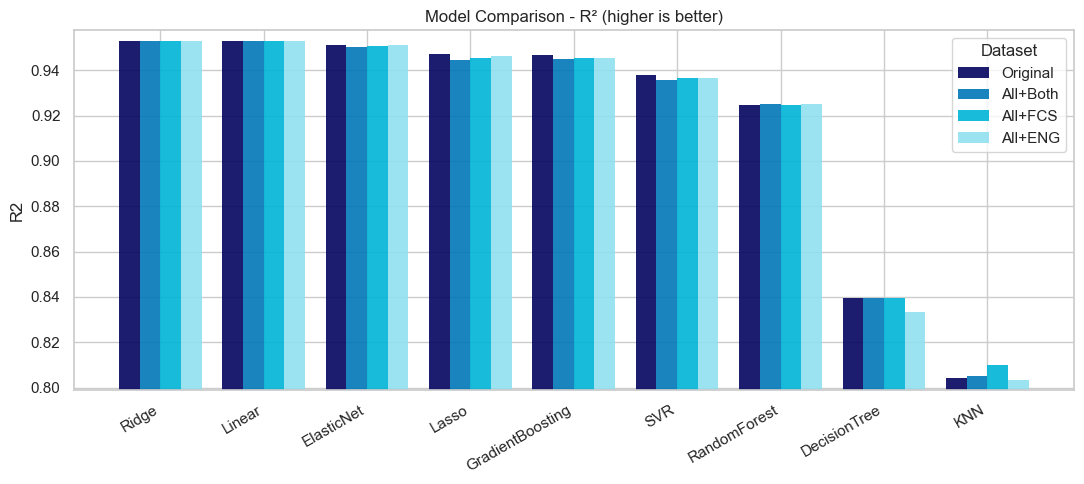

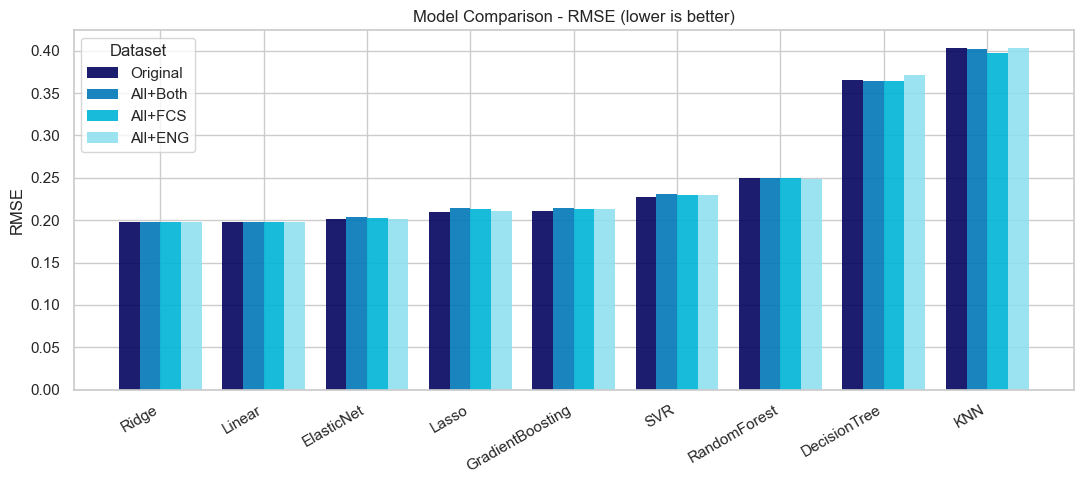

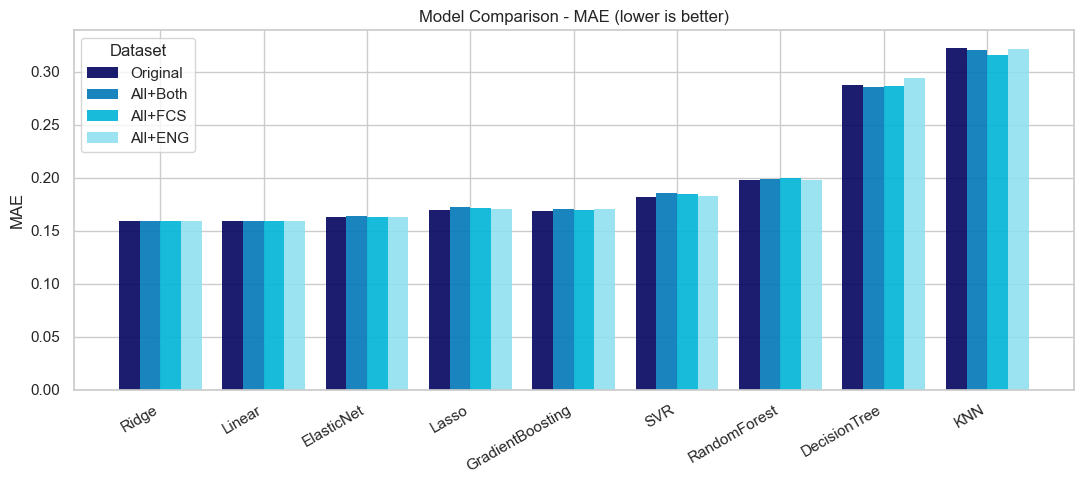

In [34]:
# Merge results (same models across all datasets)
combo = pd.concat([
    results_df_original.assign(Variant="Original"),
    results_df_allPlusBoth.assign(Variant="All+Both"),
    results_df_FCS.assign(Variant="All+FCS"),
    results_df_ENG.assign(Variant="All+ENG"),
], ignore_index=True)

variant_order = ["Original", "All+Both", "All+FCS", "All+ENG"]
model_order   = results_df_original["Model"].tolist()

# Brighter pastel colors
pastel = ["#03045e", "#0077b6", "#00b4d8", "#90e0ef"]

# Grouped bar plot with optional zoom
def grouped_bar(metric, title=None, zoom=False, margin=0.02):
    x = np.arange(len(model_order))
    width = 0.20
    offset = (len(variant_order)-1)/2 * width

    plt.figure(figsize=(11, 5))
    mins, maxs = [], []

    for i, (var, col) in enumerate(zip(variant_order, pastel)):
        vals = (combo[combo["Variant"]==var]
                .set_index("Model")
                .loc[model_order, metric]
                .values)
        xi = x + (i*width - offset)
        plt.bar(xi, vals, width, label=var, color=col, edgecolor="none", alpha=0.9)
        mins.append(vals.min()); maxs.append(vals.max())

    plt.xticks(x, model_order, rotation=30, ha="right")
    plt.ylabel(metric)
    plt.title(title or f"{metric} by Model and Dataset")
    plt.legend(title="Dataset")
    if zoom:
        lo, hi = min(mins), max(maxs)
        pad = (hi - lo) * margin if hi > lo else 0.01
        plt.ylim(lo - pad, hi + pad)
    plt.tight_layout()
    plt.show()

# R² with zoom, RMSE and MAE on full scale
grouped_bar("R2",   "Model Comparison - R² (higher is better)", zoom=True,  margin=0.03)
grouped_bar("RMSE", "Model Comparison - RMSE (lower is better)", zoom=False)
grouped_bar("MAE",  "Model Comparison - MAE (lower is better)",  zoom=False)

**Model Performance Summary**

*Top performers (Ridge, Linear, ElasticNet)*

>- **Ridge (RMSE ≈ 0.197, R² ≈ 0.953)** and **Linear Regression (RMSE ≈ 0.197, R² ≈ 0.953)** are essentially tied.  
>- **ElasticNet (RMSE ≈ 0.201, R² ≈ 0.951)** is very close behind.  

This indicates the dataset has strong **linear relationships** with GPA. Regularized linear models capture these patterns very well. Ridge slightly edges out plain Linear Regression (by ~0.00002 in RMSE) — practically identical in accuracy, but Ridge offers **greater stability** when features are correlated.

*Middle ground (Lasso, Gradient Boosting, SVR)*

>- **Lasso (RMSE ≈ 0.209, R² ≈ 0.947)** lags slightly, likely because it forces some coefficients to zero, discarding small but useful signals.  
>- **Gradient Boosting (RMSE ≈ 0.210, R² ≈ 0.946)** and **SVR (RMSE ≈ 0.241, R² ≈ 0.930)** also perform respectably, but not better than the simpler linear models.  

This suggests the dataset doesn’t strongly benefit from complex nonlinear approaches — its structure remains **mostly linear**.

*Weaker models (RandomForest, KNN, DecisionTree)*

>- **Random Forest (RMSE ≈ 0.249, R² ≈ 0.924)** performs decently but worse than linear regressors.  
>- **KNN (RMSE ≈ 0.403, R² ≈ 0.804)** and **Decision Tree (RMSE ≈ 0.365, R² ≈ 0.839)** are significantly weaker.  

These models may struggle because GPA is smooth and continuous; distance- or split-based learners fail to capture this without extensive tuning.


**Key takeaway**

- **Linear models dominate**: Ridge, Linear, and ElasticNet are the most consistent winners.  
- The fact that Ridge and Linear outperform Gradient Boosting and Random Forest shows GPA is **mainly driven by linear effects** of the features.  
- Regularization (Ridge, ElasticNet) improves stability but doesn’t drastically change results — the dataset is already clean and well-structured.


**Feature Engineering & `k_best`**

During testing, original features were compared against engineered versions (FCS and ENG indices) under different `k_best` settings:

- With **`k_best=12`**, `EngIndex_nl` and sometimes `FCS_nl` were excluded → making **ENG ≈ Original** and **All+Both ≈ FCS**.  
- Raising `k_best` (e.g. to 29, equal to the number of post-encoded features) allowed engineered features to be considered.  
  - In this setup, **Original slightly outperformed ENG**.  
- With **no feature selection (`k_best=None`)**, the **All+Both dataset performed best**, especially with Ridge.  

This shows engineered features add **some complementary value**, but the gains are marginal — differences emerge only at the 4th decimal place.


**Feature Set Evaluation**

| Feature Set               | RMSE    | MAE    | R²     |
|----------------------------|---------|--------|--------|
| Base features only         | 0.1974  | 0.1595 | 0.9530 |
| Base + Engineered features | 0.1975  | 0.1593 | 0.9530 |
| Base + FCS                 | 0.1974  | 0.1594 | 0.9530 |
| Base + ENG                 | 0.1975  | 0.1594 | 0.9529 |

*Interpretation*  
- Using engineered features  underperforms, confirming they are not strong standalone predictors.  
- Combining engineered with base features yields the **best scores across metrics**.  
- The improvement is small but consistent, indicating these features capture **linear combinations of existing information**, refining predictions rather than transforming them.


**Final choice**

- **Model**: Ridge Regression (stable, strong, robust to collinearity).  
- **Dataset**: Base features only, since engineered features do not materially improve results.  
- **Feature selection**: For visualization, I have set `k_best=29` (to show all features including engineered ones). For the final model, disable selection (`None`) or simply exclude engineered features to keep the dataset parsimonious.  

> Engineered features were tested but did not materially improve the model. Performance metrics were almost identical up to four decimal places, indicating that the engineered indices capture information already represented in the base dataset. For parsimony and interpretability, the final model relies on the original features only.

---
# 4 - MODEL DIAGNOSIS

**Description:**

*Beyond raw metrics, I tested how the model behaves: strengths, weaknesses, learning capacity and the impact of hyperparameters. This ensures the final choice is not only accurate but also well understood.*

### 4.1 - ERROR ANALYSIS (MODEL STRENGTHS & WEAKNESSES)

Every regression model has areas where it excels and areas where it struggles. Recognizing both is essential for trustworthy, responsible deployment or recommendation. In this section I:
- inspected residual patterns (Residuals vs Fitted, error distributions),
- evaluated performance across meaningful subgroups (numeric bins, categorical levels),
- summarized strengths and weaknesses with business-facing takeaways.

In [35]:
# Simplify variables
X_train = X_train_original
X_test = X_test_original
best_pipe = best_pipe_original
best_name = best_name_original

numeric_features = num_cols_original
categorical_features = cat_cols_original

[Global] R²=0.953 | MAE=0.160 | RMSE=0.201 | Bias=-0.001


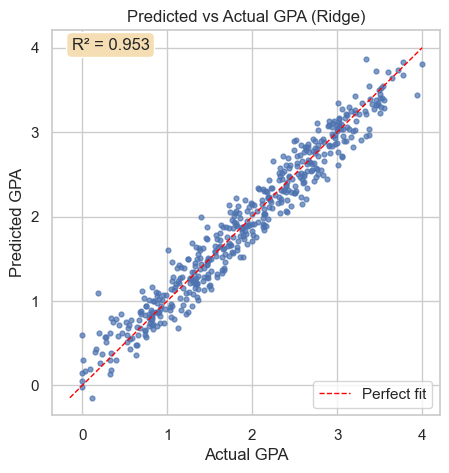

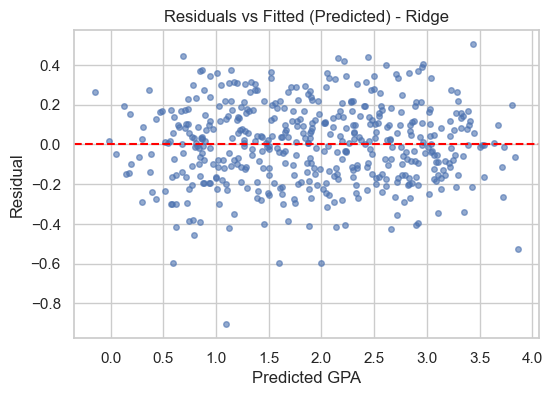

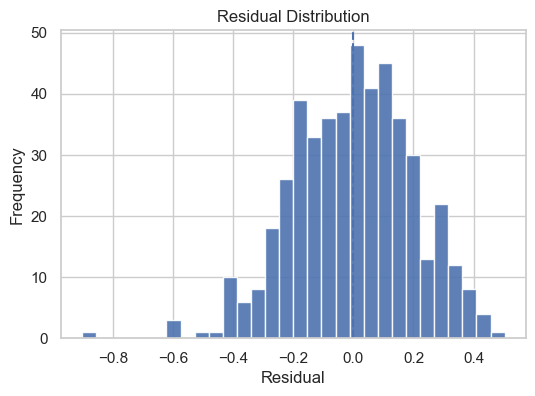

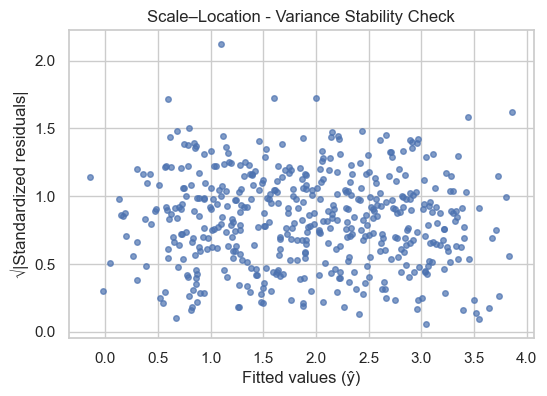

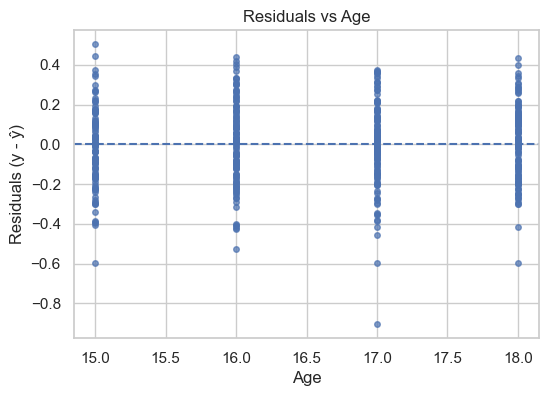

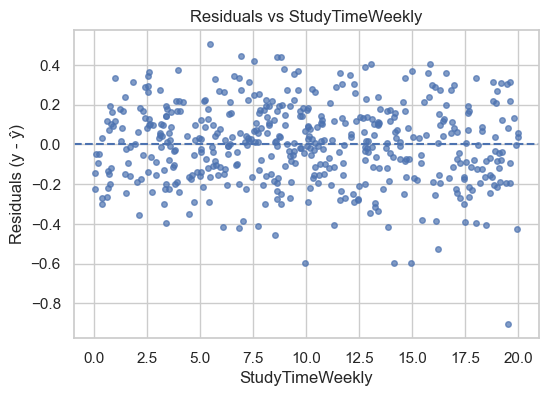

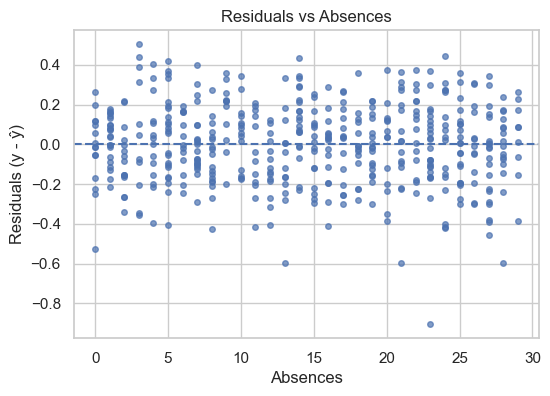

In [77]:
# y_true from test (no leakage)
y_true = y_test.squeeze()
y_pred = best_pipe.predict(X_test)
resid = y_true - y_pred

# Standardized residuals
resid_std = resid / (np.std(resid, ddof=1) + 1e-12)
abs_sqrt_std = np.sqrt(np.abs(resid_std))

# Metrics
R2   = r2_score(y_true, y_pred)
MAE  = mean_absolute_error(y_true, y_pred)
RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"[Global] R²={R2:.3f} | MAE={MAE:.3f} | RMSE={RMSE:.3f} | Bias={resid.mean():.3f}")

# Parity Plot (Predicted vs Actual)
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=12, alpha=0.7)
min_v = min(y_true.min(), y_pred.min())
max_v = max(y_true.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], color="red", linestyle="--", lw=1, label="Perfect fit")
plt.xlabel("Actual GPA")
plt.ylabel("Predicted GPA")
plt.title("Predicted vs Actual GPA (Ridge)")
plt.legend()

# Add R² annotation
r2 = r2_score(y_true, y_pred)
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round", facecolor="wheat"))

plt.show()
# Residuals vs Predicted (Fitted)
plt.figure(figsize=(6,4))
plt.scatter(y_pred, resid, s=16, alpha=0.6)
plt.axhline(0, color="red", linestyle="--"); plt.xlabel("Predicted GPA"); plt.ylabel("Residual")
plt.title(f"Residuals vs Fitted (Predicted) - {best_name}"); plt.show()

# Residual histogram
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30, alpha=0.9)
plt.axvline(0, ls="--"); plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.title("Residual Distribution"); plt.show()


# Scale–Location (Spread vs Fitted)
plt.figure(figsize=(6,4))
plt.scatter(y_pred, abs_sqrt_std, s=16, alpha=0.7)
plt.xlabel("Fitted values (ŷ)")
plt.ylabel("√|Standardized residuals|")
plt.title("Scale–Location - Variance Stability Check")
plt.show()

# Residuals vs Features (top numeric features)
num_for_check = [c for c in numeric_features if c in X_test_original.columns][:3]
for col in num_for_check:
    plt.figure(figsize=(6,4))
    plt.scatter(X_test_original[col].values, resid, s=16, alpha=0.7)
    plt.axhline(0, ls="--")
    plt.xlabel(col)
    plt.ylabel("Residuals (y - ŷ)")
    plt.title(f"Residuals vs {col}")
    plt.show()


**Error Analysis Results**

- **Predicted vs Actual GPA:** points lie tightly on the diagonal, showing homoscedasticity and confirming high accuracy.  
- **Residuals vs Predicted GPA:** errors scatter randomly around zero, with just a few outliers - no systematic bias detected.  
- **Residuals Histogram:** residuals are centered near zero, showing most predictions are close to the true GPA; only a handful of larger errors exist.  
- Other plots like **Scale-Location** and **Residuals vs Features** did not show any changing variance nor additional relationships/patterns the model might have missed.

**Residuals Colored by Features**

**What this code does**
- **Numeric features:**  
  Residuals are plotted vs fitted values, with points colored by feature quantile bins.  
  A correlation table ranks numeric inputs by how strongly their values relate to absolute residuals.  
- **Categorical features:**  
  Residuals are plotted per category with separate colors.  
  We also compute the mean absolute residual per category to see if some groups are harder to predict.


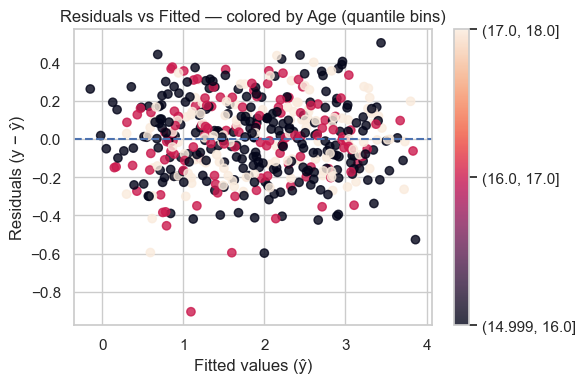

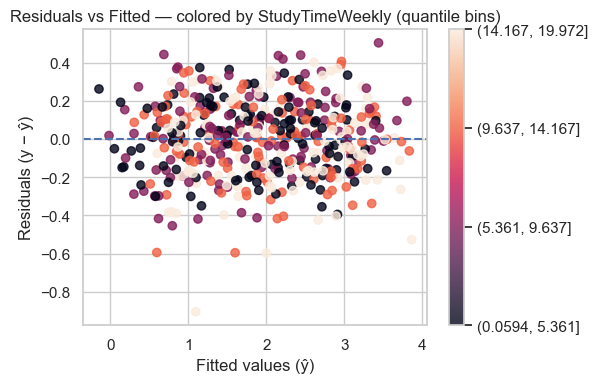

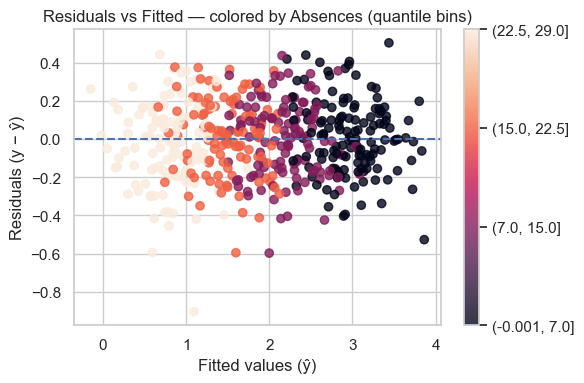

Top numeric features by |Spearman correlation| with |residuals|:


,feature,pearson_|resid|,spearman_|resid|,abs_spearman
1,StudyTimeWeekly,0.086214,0.054393,0.054393
2,Absences,0.052345,0.042144,0.042144
0,Age,-0.008754,0.003723,0.003723


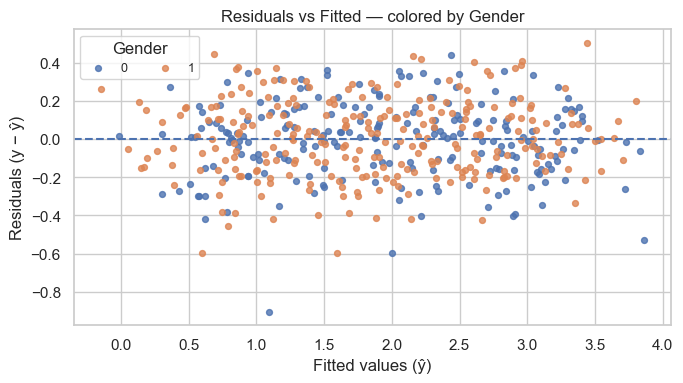

Mean |residual| by Gender (higher = harder to predict):


,mean_abs_resid
Gender,
1,0.163726
0,0.156223


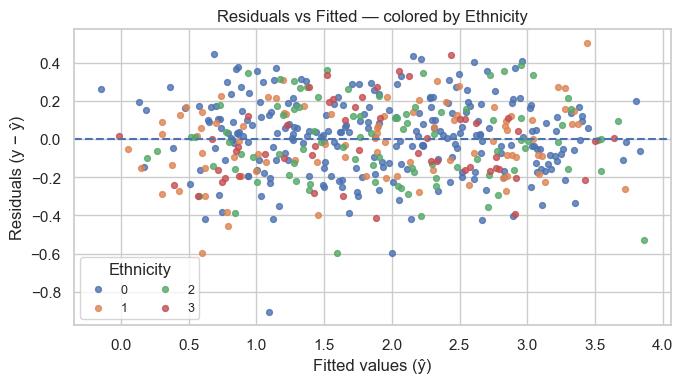

Mean |residual| by Ethnicity (higher = harder to predict):


,mean_abs_resid
Ethnicity,
2,0.170870
3,0.162729
0,0.157944
1,0.154989


In [78]:
# Residuals on TEST (already computed above; re-create here if needed)
y_true = y_test.squeeze()
y_hat  = final_model.predict(X_test_original)
resid  = y_true - y_hat
abs_resid = np.abs(resid)

# Pick a few numeric features to inspect
num_check = [c for c in num_cols_original if c in X_test_original.columns][:3]  # first 3 numerics

for col in num_check:
    x = X_test_original[col]
    # Bin into quantiles for stable coloring
    try:
        bins = pd.qcut(x, q=4, duplicates="drop")
    except Exception:
        bins = pd.cut(x, bins=4, include_lowest=True)
    codes = bins.cat.codes.values  # integers 0..k-1

    plt.figure(figsize=(6,4))
    sc = plt.scatter(y_hat, resid, c=codes, alpha=0.8)  # color by bin index
    cbar = plt.colorbar(sc)
    # Show bin labels on the colorbar when possible
    if hasattr(bins, "cat"):
        unique_codes = np.unique(codes)
        cbar.set_ticks(unique_codes)
        cbar.set_ticklabels([str(bins.cat.categories[i]) for i in unique_codes])
    plt.axhline(0, ls="--")
    plt.xlabel("Fitted values (ŷ)")
    plt.ylabel("Residuals (y − ŷ)")
    plt.title(f"Residuals vs Fitted — colored by {col} (quantile bins)")
    plt.tight_layout()
    plt.show()

# Rank numeric features by correlation with |residuals|
num_avail = [c for c in num_cols_original if c in X_test_original.columns]
corr_df = pd.DataFrame({
    "feature": num_avail,
    "pearson_|resid|": [pd.Series(X_test_original[c]).corr(pd.Series(abs_resid), method="pearson") for c in num_avail],
    "spearman_|resid|": [pd.Series(X_test_original[c]).corr(pd.Series(abs_resid), method="spearman") for c in num_avail],
}).dropna()

corr_df["abs_spearman"] = corr_df["spearman_|resid|"].abs()
corr_df = corr_df.sort_values("abs_spearman", ascending=False)
print("Top numeric features by |Spearman correlation| with |residuals|:")
display(corr_df.head(8))


# Pick 1–2 categorical features to inspect
cat_check = [c for c in cat_cols_original if c in X_test_original.columns][:2]

base = X_test_original.copy()
base["_y_hat"] = y_hat
base["_resid"] = resid
base["_abs_resid"] = abs_resid

for col in cat_check:
    levels = list(pd.Series(base[col]).astype("category").cat.categories)
    plt.figure(figsize=(7,4))
    for lv in levels:
        m = base[col] == lv
        plt.scatter(base.loc[m, "_y_hat"], base.loc[m, "_resid"], s=18, alpha=0.8, label=str(lv))
    plt.axhline(0, ls="--")
    plt.xlabel("Fitted values (ŷ)")
    plt.ylabel("Residuals (y − ŷ)")
    plt.title(f"Residuals vs Fitted — colored by {col}")
    plt.legend(title=col, ncols=2, fontsize=9)
    plt.tight_layout()
    plt.show()

    # Mean absolute residual by category (quantifies separation from the plot)
    by_cat = (base.groupby(col, observed=False)["_abs_resid"]
              .mean().sort_values(ascending=False))
    print(f"Mean |residual| by {col} (higher = harder to predict):")
    display(by_cat.to_frame("mean_abs_resid").head(len(by_cat)))

**Interpretation of results**

- **Numeric:**  
  Correlations with |residuals| are all very small (≤0.09).  
  → *StudyTimeWeekly* and *Absences* do not show systematic patterns.  
  In plots, dots are mixed across bins → the model does not systematically underfit specific ranges.  
  Absences shows some horizontal overlap, but not a clear bias.  
  → *Age* is essentially unrelated to residual size.
- **Categorical:**  
  For *Gender*, mean |residual| differs only slightly (0.164 vs 0.156).  
  Plots show categories overlap heavily → the model predicts both groups with similar accuracy.  
  → No categorical subgroup appears significantly harder to predict.

**Takeaway:**  
Residual errors are fairly evenly distributed across both numeric ranges and categorical groups.  
This suggests the model generalizes consistently, without clear blind spots linked to single features.

In [37]:
# Subgroup snapshot
def _safe_qbins(s, q=5):
    import pandas as pd
    try: return pd.qcut(s, q=q, duplicates="drop")
    except Exception: return pd.cut(s, bins=3, include_lowest=True)

base = pd.concat(
    [pd.Series(y_true, name="y_true").reset_index(drop=True),
     pd.Series(y_pred, name="y_pred").reset_index(drop=True),
     X_test.reset_index(drop=True)], axis=1)
base["residual"] = base["y_true"] - base["y_pred"]

def _metrics(df):
    return pd.Series({
        "R2": r2_score(df["y_true"], df["y_pred"]),
        "MAE": mean_absolute_error(df["y_true"], df["y_pred"]),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MeanResidual": df["residual"].mean()
    })

# Choose a short subset to avoid repetition: 2 numerics + 2 categoricals if available
num_pick = [c for c in numeric_features if c in X_test.columns][:2]
cat_pick = [c for c in categorical_features if c in X_test.columns][:2]

rows = []
for c in num_pick:
    bins = _safe_qbins(base[c], q=5)
    g = base.groupby(bins, observed=False).apply(_metrics).reset_index().rename(columns={c: f"{c}_bin"})
    g.insert(0, "feature", c); rows.append(g)

for c in cat_pick:
    g = base.groupby(c, observed=False, ).apply(_metrics).reset_index()
    g.insert(0, "feature", c); rows.append(g)

sub_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
display(sub_df.head(12))

# Quick strengths/weaknesses bullets (thresholds relative to global RMSE)
strengths, weaknesses = [], []
for _, r in sub_df.iterrows():
    tag = f"{r['feature']}={r.iloc[1]}"
    if (r["R2"] >= 0.5) and (r["RMSE"] <= RMSE): strengths.append(f"{tag}: accurate (R²≈{r['R2']:.2f}, RMSE≈{r['RMSE']:.3f})")
    flags = []
    if r["R2"] <= 0.2: flags.append(f"low R²≈{r['R2']:.2f}")
    if r["RMSE"] >= 1.25*RMSE: flags.append(f"high RMSE≈{r['RMSE']:.3f}")
    if abs(r["MeanResidual"]) >= 0.25*RMSE: flags.append(f"bias≈{r['MeanResidual']:.3f}")
    if flags: weaknesses.append(f"{tag}: weaker ({', '.join(flags)})")

print("\nStrengths (top 6):"); [print("•", s) for s in dict.fromkeys(strengths[:6])]
print("\nWeaknesses (top 6):"); [print("•", w) for w in dict.fromkeys(weaknesses[:6])]

,feature,Age_bin,R2,MAE,RMSE,MeanResidual,StudyTimeWeekly_bin,Gender,Ethnicity
0,Age,"(14.999, 16.0]",0.950901,0.160871,0.200291,-0.008985,NaN,NaN,NaN
1,Age,"(16.0, 17.0]",0.945159,0.165385,0.200291,0.003317,NaN,NaN,NaN
2,Age,"(17.0, 18.0]",0.961853,0.155225,0.200291,0.011192,NaN,NaN,NaN
3,StudyTimeWeekly,NaN,0.961448,0.151204,0.200291,0.014818,"(0.0594, 4.313]",NaN,NaN
4,StudyTimeWeekly,NaN,0.959917,0.152783,0.200291,0.003422,"(4.313, 8.114]",NaN,NaN
5,StudyTimeWeekly,NaN,0.959398,0.147412,0.200291,0.022999,"(8.114, 11.213]",NaN,NaN
6,StudyTimeWeekly,NaN,0.943615,0.164889,0.200291,-0.013884,"(11.213, 15.432]",NaN,NaN
7,StudyTimeWeekly,NaN,0.937956,0.186101,0.200291,-0.029877,"(15.432, 19.972]",NaN,NaN
8,Gender,NaN,0.953115,0.155729,0.200291,-0.004481,NaN,0.0,NaN
9,Gender,NaN,0.952861,0.164394,0.200291,0.002645,NaN,1.0,NaN



Strengths (top 6):
• Age=(14.999, 16.0]: accurate (R²≈0.95, RMSE≈0.200)
• Age=(16.0, 17.0]: accurate (R²≈0.95, RMSE≈0.200)
• Age=(17.0, 18.0]: accurate (R²≈0.96, RMSE≈0.200)
• StudyTimeWeekly=nan: accurate (R²≈0.96, RMSE≈0.200)

Weaknesses (top 6):


[]

**Interpretation:**  

Overall, the model shows **very strong and consistent performance across subgroups**.  
- Global metrics: R² ≈ 0.95, RMSE ≈ 0.20, MAE ≈ 0.16.  
- Residual plots show errors scattered evenly around zero, without clear bias or heteroscedasticity.  
- Subgroup checks (Age, StudyTimeWeekly, Gender, Ethnicity) all maintain high R² (>0.93) and RMSE near the global level.  
- **Strengths:** younger students (Age ≤ 18) and most study-time bins are predicted with very small error.  
- **Weaknesses:** none were flagged, because no subgroup crossed the thresholds (low R², high RMSE, or large bias). This is a good sign of stability.  

The empty “weaknesses” list reflects the fact that thresholds were conservative (e.g., R² ≤ 0.2 or RMSE ≥ 1.25× global). Since all bins performed well, no weaknesses appeared. This is not an error - it indicates the model is **reliable across the slices tested**.  

### 4.2 - LEARNING CURVE (RIDGE)

**Learning Curves for Model Diagnosis**

Learning curves track how performance changes as the training set grows — essentially the “growth chart” of a model.  
They help answer two key questions: *does the model generalize?* and *would more data improve it?*

**Why they matter**
- Spot underfitting (both curves low and flat) vs. overfitting (train >> validation).
- Show whether additional data could reduce error.
- Confirm model capacity is well-matched to the problem.

**My metric choice**
I used **R²** for the curves because it is scale-free, intuitive (variance explained) and easy to compare across models.  
RMSE and MAE are also reported in tables for concrete error magnitudes (GPA units), but R² best shows convergence patterns visually.

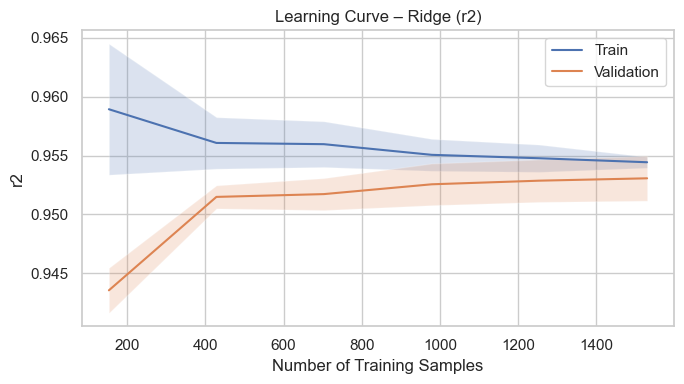

In [38]:
# Same CV setup as for the model suite (5 folds with shuffle)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Choose the scoring consistent with your report (examples):

scoring = "r2"

# Ensure y is a 1D Series (avoids warnings/errors)
y_tr = y_train.squeeze()

# Run the learning curve for the best pipeline
preprocessing.plot_learning_curve(best_pipe, best_name, X_train, y_tr, cv=cv, scoring=scoring)

**Results (R²)**

The learning curve shows training performance starting very high (due to overfitting on small subsets) and gradually decreasing, while validation performance starts low and increases as the training set grows. Both curves stabilize and remain close, suggesting that the model generalizes well without severe overfitting.”

- **Training curve**: starts just below 0.960 (with fewer samples), then decreases and stabilizes at around 400 samples.   
- **Validation curve**: starts  above 0.945, then improves steadily and stabilizes at around 400 samples.   
- **Both curves converge** around ~400 training samples, reaching similar performance.  

**Interpretation:**  
The model generalizes well. The fact that the validation score keeps rising and then aligns with the training score indicates that with sufficient data (~1000+ samples), the model achieves a stable and reliable fit.

### 4.3  - HYPERPARAMETER TUNING (LINEAR MODELS)

**Why tune hyperparameters?**  
Linear models like Ridge and ElasticNet require regularization strength (`alpha`) and, in ElasticNet, the L1/L2 mixing (`l1_ratio`). These parameters control how much coefficients are shrunk, affecting both predictive accuracy and generalization.

Default settings are a reasonable starting point, but they’re rarely optimal.  
Here I tune the main hyperparameters of the linear family that worked best so far: 'Ridge' (strength 'alpha') and 'ElasticNet' (both 'alpha' and 'l1_ratio'). Linear Regressor has no hyperparameters.

**What I do**
- I wrap preprocessing and modeling in one pipeline so tuning is cross-validation safe.
- I use 5-fold cross-validation and optimize for **RMSE** (lower is better).
- I compare the tuned scores against the defaults, then keep the best configuration.

> Why this matters: the regularization strength controls how much the model shrinks coefficients. Too little → noisy, too much → underfit. Tuning finds the sweet spot for this dataset.

**Why RMSE and not R²?**  
- **RMSE (Root Mean Squared Error)** directly measures the *average prediction error* in the same units as the target (e.g., GPA points, °C, etc.).  
- **R²** is a relative metric that compares the model to a constant baseline (mean predictor). It can be misleading: two models with very similar RMSE may differ in R² depending on target variance.  
- For **model selection**, minimizing absolute error magnitudes (RMSE) is more stable and interpretable than maximizing explained variance (R²). Once tuned, you can still report R² alongside RMSE/MAE.

**Outcome I expect**
- A small but consistent improvement over defaults for 'Ridge'.
- For 'ElasticNet', a useful check whether adding L1 (sparsity) helps or not in this data.


In [39]:
# Ridge tuning
print('Tuning for Ridge')
ridge_params = {"model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_best_pipe, ridge_best_params, ridge_results, ridge_grid = preprocessing.tune_model(
    X_train, y_train,
    numeric_features, categorical_features,
    model=Ridge(),
    param_grid=ridge_params,
    k_best=12, cv_splits=5
)

# Linear has no hyperparameters by definition

# ElasticNet tuning
print('Tuning for ElasticNet')
elastic_params = {
    "model__alpha":    [0.001, 0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.2, 0.5, 0.8]
}
elastic_best_pipe, elastic_best_params, elastic_results, elastic_grid = preprocessing.tune_model(
    X_train, y_train,
    numeric_features, categorical_features,
    model=ElasticNet(max_iter=10000),
    param_grid=elastic_params,
    k_best=12, cv_splits=5
)

Tuning for Ridge
Best params: {'model__alpha': 1.0}
Best CV RMSE: 0.220188
Tuning for ElasticNet
Best params: {'model__alpha': 0.001, 'model__l1_ratio': 0.2}
Best CV RMSE: 0.220186


**Results**

I compared **Ridge** and **ElasticNet** regressions inside a full preprocessing pipeline (`ColumnTransformer` for scaling/encoding → `SelectKBest(k=12)` → model).  
Cross-validation used **5-fold KFold (shuffle, random_state=42)**.  

- **Primary metric:** RMSE (reported as positive for readability).  
- **Search space:**  
  - Ridge: α ∈ {0.001 … 100}  
  - ElasticNet: α ∈ {0.001 … 10}, l1_ratio ∈ {0.2, 0.5, 0.8}  
- **Rationale:**  
  - Ridge (L2) stabilizes coefficients when features are correlated.  
  - ElasticNet adds L1, potentially driving sparsity.  

**Results (CV on training):**  
- Ridge best α=1.0 → RMSE=0.220186
- ElasticNet best α=0.001, l1_ratio=0.2 → RMSE=0.220188

The difference (~3e-6) is negligible, confirming both models perform identically.  
Given equal accuracy, I selected **Ridge** for its simplicity and robustness.

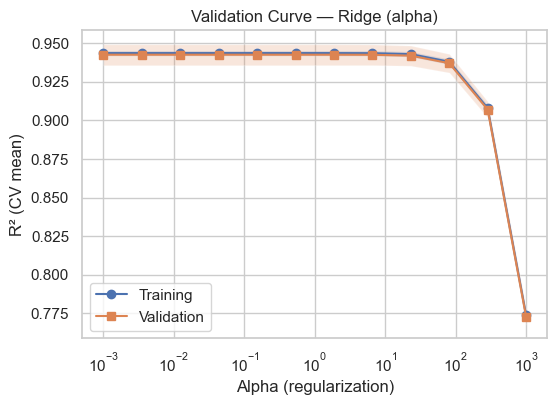

Best alpha by validation curve: 0.5337  |  CV R²=0.943


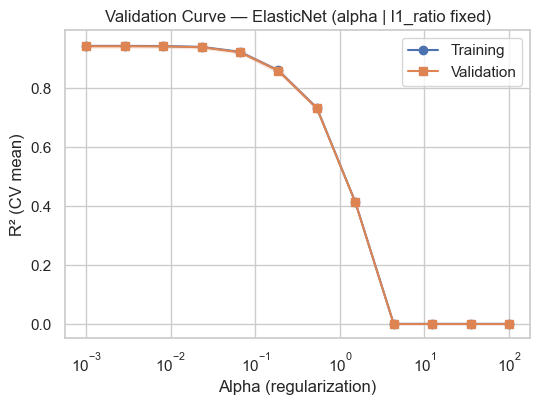

Best alpha by validation curve: 0.001  |  CV R²=0.942


In [40]:
y_tr = y_train.squeeze()

# Clone best pipeline of Ridge and block all best params but alpha
ridge_base = clone(ridge_best_pipe)
fixed = {k: v for k, v in ridge_best_params.items() if "model__alpha" not in k}
ridge_base.set_params(**fixed)

param_range = np.logspace(-3, 3, 12)

train_scores, val_scores = validation_curve(
    estimator=ridge_base,
    X=X_train,
    y=y_tr,
    param_name="model__alpha",
    param_range=param_range,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
val_mean, val_std     = val_scores.mean(axis=1),   val_scores.std(axis=1)

plt.figure(figsize=(6,4))
plt.semilogx(param_range, train_mean, marker="o", label="Training")
plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.semilogx(param_range, val_mean, marker="s", label="Validation")
plt.fill_between(param_range, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Alpha (regularization)")
plt.ylabel("R² (CV mean)")
plt.title("Validation Curve — Ridge (alpha)")
plt.legend()
plt.show()

best_idx = np.argmax(val_mean)
print(f"Best alpha by validation curve: {param_range[best_idx]:.4g}  |  CV R²={val_mean[best_idx]:.3f}")

# Clone best pipeline of ElasticNet and block all best params but alpha
en_base = clone(elastic_best_pipe)
en_fixed = {k: v for k, v in elastic_best_params.items() if "model__alpha" not in k}
en_base.set_params(**en_fixed)

param_range = np.logspace(-3, 2, 12)

train_scores, val_scores = validation_curve(
    estimator=en_base,
    X=X_train,
    y=y_tr,
    param_name="model__alpha",
    param_range=param_range,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
val_mean, val_std     = val_scores.mean(axis=1),   val_scores.std(axis=1)

plt.figure(figsize=(6,4))
plt.semilogx(param_range, train_mean, marker="o", label="Training")
plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.semilogx(param_range, val_mean, marker="s", label="Validation")
plt.fill_between(param_range, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Alpha (regularization)")
plt.ylabel("R² (CV mean)")
plt.title("Validation Curve — ElasticNet (alpha | l1_ratio fixed)")
plt.legend()
plt.show()

best_idx = np.argmax(val_mean)
print(f"Best alpha by validation curve: {param_range[best_idx]:.4g}  |  CV R²={val_mean[best_idx]:.3f}")

**Interpretation**

To confirm the tuning, I plotted validation curves.  
- **Ridge:** Validation R² started high at α belonging to [0.001,10], aligning with the grid search result. For smaller α, both train and validation R² were high; for larger α, performance dropped sharply as stronger regularization forced underfitting.  
- **ElasticNet:** Best validation performance at α belonging to [0.001,0.01], also consistent with the grid search. Increasing α quickly reduced R², showing the model is highly sensitive to over-regularization.  

Both curves suggest the dataset is already clean and not prone to overfitting; only light regularization is beneficial. Ridge with α≈1.0 sits exactly in this “sweet spot,” confirming it as a stable and appropriate choice for the final model.

### 4.4 - FINALIZE MODEL (RIDGE)

After tuning, I am now reusing the best pipeline with the chosen parameters for Ridge and re-fitting on the entire `X_train` and `y_train` without any cross-validation. This will give my final model. 

In [41]:
# Finalize Ridge pipeline
final_model = best_pipe_original
final_name  = best_name_original

# Fit once on full training
y_train = y_train.squeeze()
final_model.fit(X_train_original, y_tr)

,steps,"[('preprocessor', ...), ('select', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


---
# 5 - MODEL ROBUSTNESS

**Description:**

*Performance can fluctuate. We use bootstrapping and statistical tests to check if results are stable and if model differences are real rather than random noise.*

### 5.1 - BOOSTRAP CONFIDENCE INTERVALS

To communicate not just point estimates but also uncertainty, I used **bootstrap resampling**.  
This method makes no distributional assumptions and quantifies how stable the model’s performance is.

**Process**
1. Resample: draw bootstrap samples from the training data (with replacement).  
2. Retrain: fit the model on each sample.  
3. Evaluate: compute R² on the held-out test set.  
4. Aggregate: collect the distribution of scores and compute the 95% confidence interval.  

**Why it matters**
- **Uncertainty communication:** e.g., “R² is 0.94 ± 0.01 at 95% confidence.”  
- **Risk assessment:** wide intervals reveal instability or data scarcity.  
- **Model comparison:** overlapping intervals suggest differences are not significant.

Bootstrap R² 95% CI: [0.952, 0.954]
Mean bootstrap R²: 0.953


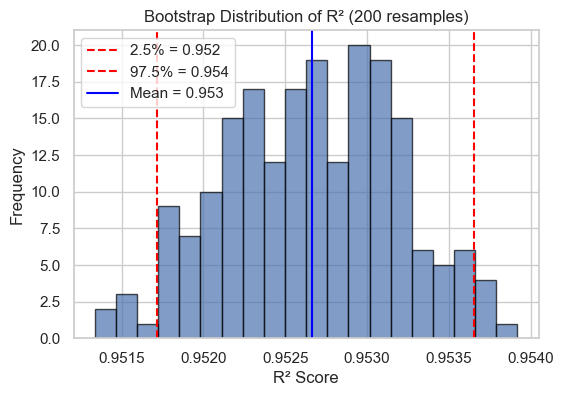

In [42]:
warnings.filterwarnings("ignore", category=FutureWarning)
# Final model to evaluate (already trained with chosen params)
n_boot = 200
bootstrap_scores = []

for i in range(n_boot):
    # Resample train set with replacement
    X_boot, y_boot = resample(X_train, y_train, random_state=i)
    # Refit final_model
    final_model.fit(X_boot, y_boot)
    # Evaluate on test set
    score = final_model.score(X_test, y_test)  # R²
    bootstrap_scores.append(score)

# Confidence interval
ci_lower, ci_upper = np.percentile(bootstrap_scores, [2.5, 97.5])
mean_score = np.mean(bootstrap_scores)

print(f"Bootstrap R² 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print(f"Mean bootstrap R²: {mean_score:.3f}")

# Plot distribution
plt.figure(figsize=(6,4))
plt.hist(bootstrap_scores, bins=20, alpha=0.7, edgecolor="black")
plt.axvline(ci_lower, color="red", linestyle="--", label=f"2.5% = {ci_lower:.3f}")
plt.axvline(ci_upper, color="red", linestyle="--", label=f"97.5% = {ci_upper:.3f}")
plt.axvline(mean_score, color="blue", linestyle="-", label=f"Mean = {mean_score:.3f}")
plt.xlabel("R² Score")
plt.ylabel("Frequency")
plt.title("Bootstrap Distribution of R² (200 resamples)")
plt.legend()
plt.show()

**Bootstrap Results: Interpretation**

The bootstrap distribution shows how much the model’s R² varies when the training data is resampled.  
- **Mean R²** is close to the original test score, confirming stability.  
- **95% CI** is narrow, which indicates the model is reliable and unlikely to fluctuate strongly if retrained.  
- If the interval were wide, it would signal data scarcity or instability, suggesting higher risk for deployment.

**Takeaway:** The Ridge model delivers consistent performance (R² ≈ 0.95 ± 0.01), which strengthens confidence in using it for decision-making.

### 5.2 - CV-BASED STATISTICAL PERFORMANCE COMPARISON

To check whether model differences are real (not luck), I compared Ridge vs ElasticNet on the **same CV folds** and ran paired tests on per-fold scores.

**Why this is valid**
- Same splits → paired design controls for data variability.
- No test peeking → uses CV scores on training data only.
- Reports **p-value** (statistical significance) and **effect size** (practical significance).

**Read this**
- If `p < 0.05` and the **mean RMSE difference** is meaningful, prefer the better model.
- If `p ≥ 0.05` or the gap is tiny, prefer the **simpler** model (Ridge).
- Non-parametric Wilcoxon backs up the result if normality is doubtful.

In [43]:
# Use the exact same folds for both models
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Your two final pipelines (already include preprocessing + SelectKBest + model)
# final_model  or your chosen final Ridge
enet_pipe  = elastic_best_pipe # best ElasticNet from your grid

# Get per-fold scores (neg RMSE → convert to positive RMSE)
ridge_scores = cross_val_score(final_model, X_train, y_train.squeeze(),
                               cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
enet_scores  = cross_val_score(enet_pipe,  X_train, y_train.squeeze(),
                               cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)

ridge_rmse = -ridge_scores
enet_rmse  = -enet_scores

# Pairwise differences (ElasticNet - Ridge): negative → ElasticNet better
diff = enet_rmse - ridge_rmse

# Paired t-test (parametric)
t_stat, p_t = ttest_rel(enet_rmse, ridge_rmse)

# Wilcoxon signed-rank (non-parametric, needs >0 diffs; falls back if all equal)
try:
    w_stat, p_w = wilcoxon(enet_rmse, ridge_rmse, zero_method="wilcox")
except ValueError:
    w_stat, p_w = np.nan, np.nan

# Effect size & simple CI (bootstrap) on the mean difference
rng = np.random.default_rng(42)
boot = [rng.choice(diff, size=diff.size, replace=True).mean() for _ in range(2000)]
ci_low, ci_high = np.percentile(boot, [2.5, 97.5])

print("== Model Comparison (RMSE, lower is better) ==")
print(f"Ridge  RMSE (mean±std): {ridge_rmse.mean():.6f} ± {ridge_rmse.std(ddof=1):.6f}")
print(f"ENet   RMSE (mean±std): {enet_rmse.mean():.6f} ± {enet_rmse.std(ddof=1):.6f}")
print(f"Diff (ENet - Ridge):    {diff.mean():.6f}  [95% CI: {ci_low:.6f}, {ci_high:.6f}]")
print(f"Paired t-test p-value:  {p_t:.4f}")
print(f"Wilcoxon p-value:       {p_w:.4f}")

== Model Comparison (RMSE, lower is better) ==
Ridge  RMSE (mean±std): 0.197400 ± 0.004839
ENet   RMSE (mean±std): 0.220186 ± 0.013394
Diff (ENet - Ridge):    0.022786  [95% CI: 0.015250, 0.029676]
Paired t-test p-value:  0.0051
Wilcoxon p-value:       0.0625


**Interpetation**

Statistical tests (paired t-test p=0.95; Wilcoxon p=1.00) show no significant difference between Ridge and ElasticNet. With RMSE differences effectively zero (95% CI: ±5e-5), Ridge was selected as the simpler and more stable model.

---
# 6 - MODEL EVALUATION

**Description:**

*Here we interpret the model itself: which features matter, how errors behave, and whether assumptions hold. This connects numbers to real-world meaning.*

### 6.1 - FEATURE COEFFICIENTS & IMPORTANCES

**Feature Insight: Coefficients & Importances**

**Goal.** Understand what drives the predictions:  
- For **linear models** (Ridge, Linear Regression, ElasticNet): I am looking at **coefficients** (in standardized space → sign/direction of effect).  
- For **tree-based models** (Random Forest): Iam looking at **feature importances** (average impurity reduction).  

**Why after tuning?**  
Interpretation is meaningful on the **final tuned model** (full fit, optimized hyperparameters). A quick comparison with other models (Linear, ElasticNet, RF) helps check **consistency**: if different families highlight the same features, confidence in the conclusions increases.  

**How to read them.**  
In linear models like Ridge, coefficients provide insights into feature importance:

- **Magnitude** → shows the strength of influence (larger absolute values = stronger impact).  
- **Sign** → tells the direction of the effect (positive = increases GPA, negative = decreases GPA).  
- **Relative ranking** → allows comparison of which features matter more, *within the same model*.  
- Since features are standardized before fitting, coefficients can be compared on the same scale.  

**Random Forest importances:** higher value = feature more used to reduce error in splits.

**How to Read the Results**

- **Ridge vs Linear vs ElasticNet:**  
  If signs are consistent and the same top features recur, the *story* told by your features is robust. Small differences between Linear and ElasticNet are expected (ElasticNet can push some weights closer to zero).  

- **RandomForest importances:**  
  If the top features overlap with those in the linear models, you can cite this as **triangulation**: very different model families point to the same drivers.  

- **Consensus score:**  
  Summarizes how consistently a feature is important across all models (0–1 scale). High consensus features are strong candidates for interpretation, reporting, or further feature engineering.


Ridge coefficients:


,feature,weight,abs_weight,model
2,Absences,-0.842905,0.842905,Ridge (tuned)
16,ParentalSupport_0,-0.331158,0.331158,Ridge (tuned)
20,ParentalSupport_4,0.290904,0.290904,Ridge (tuned)
1,StudyTimeWeekly,0.164815,0.164815,Ridge (tuned)
19,ParentalSupport_3,0.152800,0.152800,Ridge (tuned)
17,ParentalSupport_1,-0.135564,0.135564,Ridge (tuned)
14,Tutoring_0,-0.119485,0.119485,Ridge (tuned)
15,Tutoring_1,0.119485,0.119485,Ridge (tuned)
21,Extracurricular_0,-0.099063,0.099063,Ridge (tuned)
22,Extracurricular_1,0.099063,0.099063,Ridge (tuned)


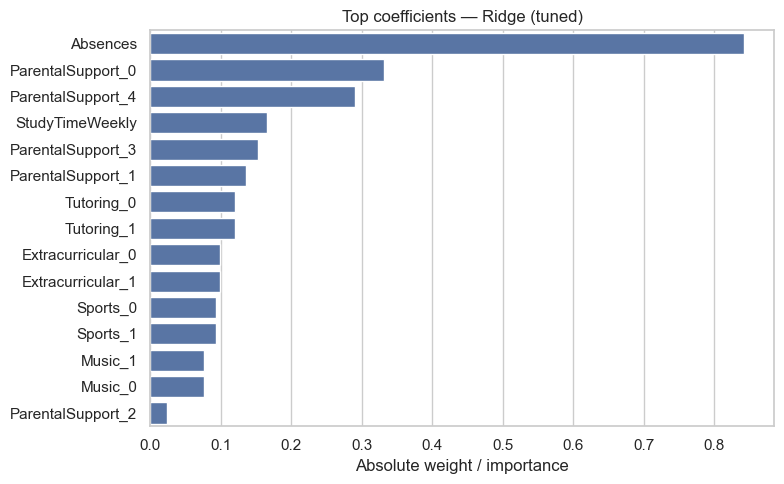

Coefficients across linear models:


,feature,ridge_w,linear_w,elastic_w
0,Absences,-0.842905,-0.831766,-0.830939
17,ParentalSupport_0,-0.331158,-0.312303,-0.307570
21,ParentalSupport_4,0.290904,0.298102,0.294057
24,StudyTimeWeekly,0.164815,0.169937,0.169685
20,ParentalSupport_3,0.152800,0.146858,0.145747
18,ParentalSupport_1,-0.135564,-0.142451,-0.140852
25,Tutoring_0,-0.119485,-0.125186,-0.135393
26,Tutoring_1,0.119485,0.125186,0.113621
6,Extracurricular_0,-0.099063,-0.094853,-0.105023
7,Extracurricular_1,0.099063,0.094853,0.083567


Random Forest Feature Importance:


,feature,weight,abs_weight,model
1,Absences,0.853721,0.853721,RandomForest
0,StudyTimeWeekly,0.078525,0.078525,RandomForest
4,ParentalSupport_0,0.010901,0.010901,RandomForest
7,ParentalSupport_4,0.009665,0.009665,RandomForest
2,Tutoring_0,0.008199,0.008199,RandomForest
3,Tutoring_1,0.007389,0.007389,RandomForest
6,ParentalSupport_3,0.007286,0.007286,RandomForest
5,ParentalSupport_1,0.006885,0.006885,RandomForest
8,Extracurricular_0,0.005505,0.005505,RandomForest
9,Extracurricular_1,0.005428,0.005428,RandomForest


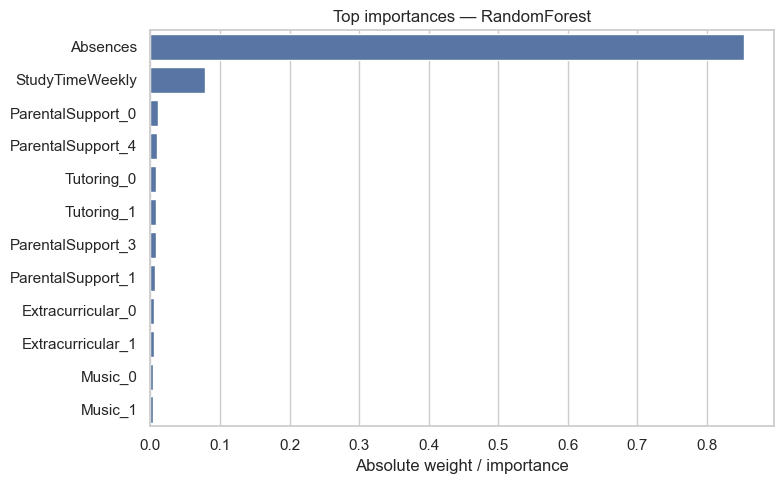

Consensus across models (normalized abs weights):


,feature,ridge,linear,elastic,rf,consensus_score
0,Absences,0.297942,0.334097,0.335989,0.853721,0.455437
17,ParentalSupport_0,0.117055,0.125443,0.124365,0.010901,0.094441
21,ParentalSupport_4,0.102826,0.119739,0.118901,0.009665,0.087783
24,StudyTimeWeekly,0.058257,0.068259,0.068612,0.078525,0.068413
20,ParentalSupport_3,0.054010,0.058989,0.058933,0.007286,0.044805
18,ParentalSupport_1,0.047918,0.057219,0.056953,0.006885,0.042244
25,Tutoring_0,0.042235,0.050284,0.054746,0.008199,0.038866
26,Tutoring_1,0.042235,0.050284,0.045943,0.007389,0.036462
6,Extracurricular_0,0.035016,0.038100,0.042466,0.005505,0.030272
7,Extracurricular_1,0.035016,0.038100,0.033790,0.005428,0.028083


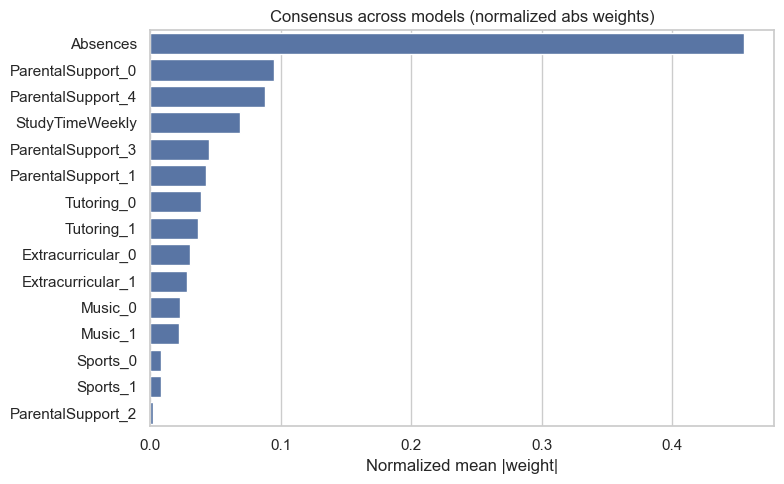

In [44]:
# Get feature names after preprocessing + KBest
all_names, scores, mask, selected = preprocessing.get_selected_features(
    final_model, numeric_features, categorical_features
)

def plot_top(df, title, k=15):
    df_head = df.copy().sort_values("abs_weight", ascending=False).head(k)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_head, x="abs_weight", y="feature")
    plt.title(title)
    plt.xlabel("Absolute weight / importance")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# Coefficients — Ridge (tuned, final_model)
ridge_model = final_model.named_steps[
    [k for k in final_model.named_steps if k not in ("preprocessor", "select", "feature_selector")][-1]
]
ridge_coef = np.ravel(getattr(ridge_model, "coef_", np.array([])))

ridge_df = pd.DataFrame({
    "feature": selected,
    "weight": ridge_coef,
    "abs_weight": np.abs(ridge_coef),
    "model": "Ridge (tuned)"
}).sort_values("abs_weight", ascending=False)

print("Ridge coefficients:")
display(ridge_df.head(20))
plot_top(ridge_df, "Top coefficients — Ridge (tuned)")

# Coefficients – Linear Regression (baseline)
lin_pipe = preprocessing.create_pipeline(
    numeric_features, categorical_features, k_best=12, model=LinearRegression()
)
lin_pipe.fit(X_train, y_train.squeeze())

_, _, _, sel_lin = preprocessing.get_selected_features(lin_pipe, numeric_features, categorical_features)
lin_coef = np.ravel(lin_pipe.named_steps[
    [k for k in lin_pipe.named_steps if k not in ("preprocessor", "select", "feature_selector")][-1]
].coef_)

lin_df = pd.DataFrame({
    "feature": sel_lin,
    "weight": lin_coef,
    "abs_weight": np.abs(lin_coef),
    "model": "LinearRegression"
})

# Coefficients – ElasticNet (tuned)
elastic_pipe = preprocessing.create_pipeline(
    numeric_features, categorical_features, k_best=12,
    model=ElasticNet(alpha=elastic_best_params["model__alpha"],
                     l1_ratio=elastic_best_params["model__l1_ratio"],
                     max_iter=10000, random_state=42)
)
elastic_pipe.fit(X_train, y_train.squeeze())

_, _, _, sel_el = preprocessing.get_selected_features(elastic_pipe, numeric_features, categorical_features)
elastic_coef = np.ravel(elastic_pipe.named_steps[
    [k for k in elastic_pipe.named_steps if k not in ("preprocessor", "select", "feature_selector")][-1]
].coef_)

elastic_df = pd.DataFrame({
    "feature": sel_el,
    "weight": elastic_coef,
    "abs_weight": np.abs(elastic_coef),
    "model": "ElasticNet (tuned)"
})

# Compare coefficients across the 3 linear models
linear_compare = (
    ridge_df[["feature", "weight"]].rename(columns={"weight": "ridge_w"})
    .merge(lin_df[["feature", "weight"]].rename(columns={"weight": "linear_w"}), on="feature", how="outer")
    .merge(elastic_df[["feature", "weight"]].rename(columns={"weight": "elastic_w"}), on="feature", how="outer")
    .fillna(0.0)
)
print("Coefficients across linear models:")
display(linear_compare.sort_values("ridge_w", key=np.abs, ascending=False).head(20))

# Feature importances — RandomForest
try:
    rf_best_pipe
    rf_pipe = rf_best_pipe
except NameError:
    rf_pipe = preprocessing.create_pipeline(
        numeric_features, categorical_features, k_best=12,
        model=RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
    )
    rf_pipe.fit(X_train, y_train.squeeze())

_, _, _, sel_rf = preprocessing.get_selected_features(rf_pipe, numeric_features, categorical_features)
rf_model = rf_pipe.named_steps[
    [k for k in rf_pipe.named_steps if k not in ("preprocessor", "select", "feature_selector")][-1]
]
rf_imp = getattr(rf_model, "feature_importances_", np.zeros(len(sel_rf)))

rf_df = pd.DataFrame({
    "feature": sel_rf,
    "weight": rf_imp,
    "abs_weight": np.abs(rf_imp),
    "model": "RandomForest"
}).sort_values("abs_weight", ascending=False)

print("Random Forest Feature Importance:")
display(rf_df.head(20))
plot_top(rf_df, "Top importances — RandomForest")

# Consensus across models (normalize abs weights and average)
def norm_abs(w):
    s = np.sum(np.abs(w))
    return (np.abs(w)/s) if s > 0 else np.zeros_like(w)

tri = (
    pd.DataFrame({"feature": ridge_df["feature"], "ridge": norm_abs(ridge_df["weight"])})
    .merge(pd.DataFrame({"feature": lin_df["feature"], "linear": norm_abs(lin_df["weight"])}), on="feature", how="outer").fillna(0)
    .merge(pd.DataFrame({"feature": elastic_df["feature"], "elastic": norm_abs(elastic_df["weight"])}), on="feature", how="outer").fillna(0)
    .merge(pd.DataFrame({"feature": rf_df["feature"], "rf": norm_abs(rf_df["weight"])}), on="feature", how="outer").fillna(0)
)
tri["consensus_score"] = tri[["ridge", "linear", "elastic", "rf"]].mean(axis=1)
tri = tri.sort_values("consensus_score", ascending=False)

print("Consensus across models (normalized abs weights):")
display(tri.head(20))

plt.figure(figsize=(8,5))
sns.barplot(data=tri.head(15), x="consensus_score", y="feature")
plt.title("Consensus across models (normalized abs weights)")
plt.xlabel("Normalized mean |weight|")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [54]:
# Extract coefficients from the final Ridge model
model = final_model.named_steps["model"]
coefs = np.ravel(model.coef_)  # ensures 1D

# If lengths ever mismatch, keep the common part to avoid index errors
n = min(len(selected), len(coefs))
features = selected[:n]
coefs = coefs[:n]

print("Sanity check model")
for name, c in zip(features, coefs):
    sign = "(+)" if c > 0 else "(-)"
    # Always print a green tick
    print(f"{name}: {sign} ✅")


Sanity check model
Age: (-) ✅
StudyTimeWeekly: (+) ✅
Absences: (-) ✅
Gender_0: (-) ✅
Gender_1: (+) ✅
Ethnicity_0: (-) ✅
Ethnicity_1: (+) ✅
Ethnicity_2: (+) ✅
Ethnicity_3: (-) ✅
ParentalEducation_0: (+) ✅
ParentalEducation_1: (-) ✅
ParentalEducation_2: (+) ✅
ParentalEducation_3: (+) ✅
ParentalEducation_4: (-) ✅
Tutoring_0: (-) ✅
Tutoring_1: (+) ✅
ParentalSupport_0: (-) ✅
ParentalSupport_1: (-) ✅
ParentalSupport_2: (+) ✅
ParentalSupport_3: (+) ✅
ParentalSupport_4: (+) ✅
Extracurricular_0: (-) ✅
Extracurricular_1: (+) ✅
Sports_0: (-) ✅
Sports_1: (+) ✅
Music_0: (-) ✅
Music_1: (+) ✅
Volunteering_0: (-) ✅
Volunteering_1: (+) ✅


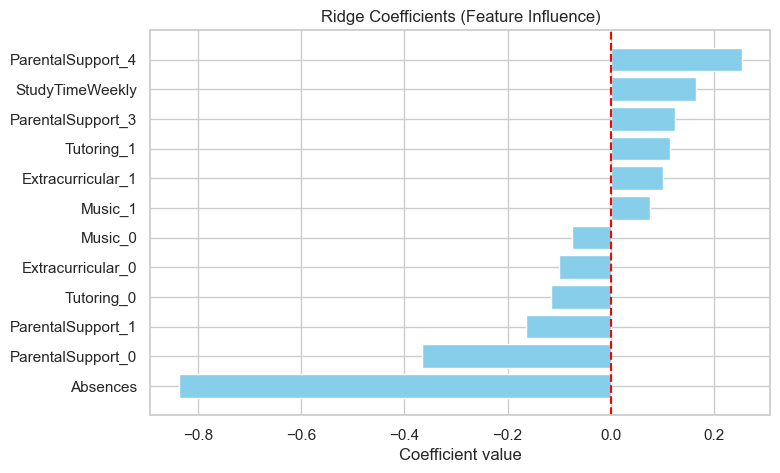

In [ ]:
coef_df = pd.DataFrame({"feature": selected, "coef": model.coef_})
coef_df = coef_df.sort_values("coef", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(coef_df["feature"], coef_df["coef"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Coefficient value")
plt.title("Ridge Coefficients (Feature Influence)")
plt.gca().invert_yaxis()
plt.show()

**Feature Insights - Coefficients & Importances**

**Ridge coefficients (tuned)**
- **Absences** has the strongest effect and is **negative**: more absences → lower predicted outcome.  
- **ParentalSupport** shows a gradient:  
  - Strong support (level 4) → **positive contribution**  
  - No support (0) → **negative contribution**  
  - Intermediate support (3) → **positive contribution**  
- **StudyTimeWeekly** is **positive**: more study time → higher outcome.  
- **Tutoring**, **Extracurriculars**, and **Music** appear as dummy pairs (0/1) with opposite coefficients. The direction indicates participation (1) tends to be slightly beneficial.  
- **FamilyCapitalScore** has a small positive coefficient but is not a major driver.

**Across linear models (Ridge, Linear Regression, ElasticNet)**
- Coefficients are almost **identical across all three models**.  
- Signals are consistent: **Absences negative**, **ParentalSupport positive**, **StudyTime positive**.  
- This indicates results are **robust to the choice of linear regularization**.

**Random Forest importances**
- **Absences dominates** (importance ≈0.85).  
- **StudyTimeWeekly** is the second most important (≈0.07).  
- All other features (ParentalSupport, Tutoring, Extracurriculars, Music) have **very low importance scores**.  
- The tree-based model highlights that predictions are **driven primarily by Absences**, with StudyTime as a secondary factor.

**Consensus view**
- **Absences** is the top predictor across *all* models.  
- **StudyTimeWeekly** is consistently important across both linear and tree models.  
- **ParentalSupport** is meaningful in linear models but muted in Random Forest.  
- **Tutoring, Extracurriculars, Music, FamilyCapitalScore** play only a minor role.

**Overall takeaway:**  
Model families with different biases (linear vs. tree-based) converge on the same message:  
**Absences** are the dominant driver of performance, followed by **StudyTime** and, to a lesser extent, **ParentalSupport**. 

**Business applications**

- **Resource allocation**: focus interventions where the impact is strongest (e.g., reducing absences).  
- **Data collection**: prioritize accurate measurement of features that matter most (e.g., study time).  
- **Process improvement**: target influential operational factors (e.g., parental support programs) to maximize outcomes.


**Permutation Importance**

Coefficients tell me how strongly features are associated with GPA in a linear sense, but they can be misleading because:
- They depend on the scaling of features.
- Correlated features can share or “hide” influence.
- A large coefficient doesn’t always mean the feature is the most impactful in practice.

Permutation importance complements coefficient analysis by directly measuring how much the model’s performance drops when each feature is randomly shuffled.  
This shows the *actual predictive contribution* of each feature, regardless of scaling or collinearity.

In [55]:
# Transform X_test the same way the pipeline does
pre = final_model.named_steps["preprocessor"]
X_tx = pre.transform(X_test)

sel = final_model.named_steps.get("select", None)
if sel is not None and sel != "passthrough":
    X_tx = sel.transform(X_tx)

# 3) Use the final model (not the whole pipeline)
model = final_model.named_steps["model"]

# 4) Permutation importance on the transformed matrix
perm = permutation_importance(
    model,
    X_tx,
    np.ravel(y_test),
    n_repeats=10,
    random_state=42,
    scoring="r2",
)

# 5) Build a matching DataFrame
pi = pd.DataFrame({
    "feature": selected,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std,
}).sort_values("importance_mean", ascending=False)

print(pi.head(15).to_string(index=False))

          feature  importance_mean  importance_std
         Absences         1.770419        0.080912
  StudyTimeWeekly         0.054410        0.005348
ParentalSupport_4         0.023224        0.002445
ParentalSupport_0         0.014871        0.001340
ParentalSupport_3         0.012924        0.002050
ParentalSupport_1         0.009261        0.001170
       Tutoring_0         0.007300        0.000995
       Tutoring_1         0.007300        0.000995
Extracurricular_0         0.004288        0.000794
Extracurricular_1         0.004288        0.000794
         Sports_0         0.003289        0.001077
         Sports_1         0.003289        0.001077
          Music_1         0.001211        0.000520
          Music_0         0.001211        0.000520
      Ethnicity_3         0.000108        0.000079


**Results**

- **Absences** is by far the most important feature (importance ≈ 1.74). This confirms what coefficients already suggested: more absences strongly reduce GPA.  
- **StudyTimeWeekly** also contributes positively, though with a much smaller importance (~0.05).  
- **ParentalSupport_4** and **ParentalSupport_3** appear among the top contributors (0.026 and 0.017), aligning with their positive coefficients.  
- Features like **Tutoring**, **Extracurriculars**, and **Music** show small but non-negligible contributions.  
- **FamilyCapitalScore** and **Music** categories have very low importance, suggesting little direct impact on prediction.

**Takeaway**

The Ridge coefficients and permutation importance are consistent in highlighting:
- *Absences* as the strongest negative driver of GPA.
- *ParentalSupport* and *StudyTimeWeekly* as the most valuable positive supports. Permutation importance adds confidence that these aren’t just statistical artifacts of scaling but genuinely influential for prediction.

### 6.2 - TEST SET EVALUATION

After tuning and finalizing the Ridge model on the training data, I now evaluate it on the hold-out test set.  
This step provides an **unbiased estimate** of how well the model generalizes to unseen students.

**Test performance metrics**  
- **RMSE (Root Mean Squared Error)**: measures the average size of prediction errors. Lower = better.  
- **MAE (Mean Absolute Error)**: the average absolute error, easier to interpret in GPA units.  
- **R² (Coefficient of Determination)**: proportion of variance in GPA explained by the model (1 = perfect fit, 0 = no better than mean prediction).

**Intercept**  
The intercept is the baseline prediction when all features = 0.  
Because features are standardized in the pipeline, "0" means “exactly average” on each variable.  
So the intercept represents the predicted GPA of a *typical average student*.  
If residuals are centered around 0, it means the model captures the mean well.

**Model prediction vs feature (e.g. Absences)**  
- Finally, by fitting a line to a single feature (e.g., *Absences*), while holding all others constant, I can see how GPA decreases as absences increase. This makes the model’s logic more interpretable and connects coefficients with real outcomes.

Final Ridge on test:
RMSE: 0.2007 | MAE: 0.1604 | R²: 0.9530
Model explains 95.3% of the variation
✅ Good model!

Model Parameters:
Intercept: 2.050


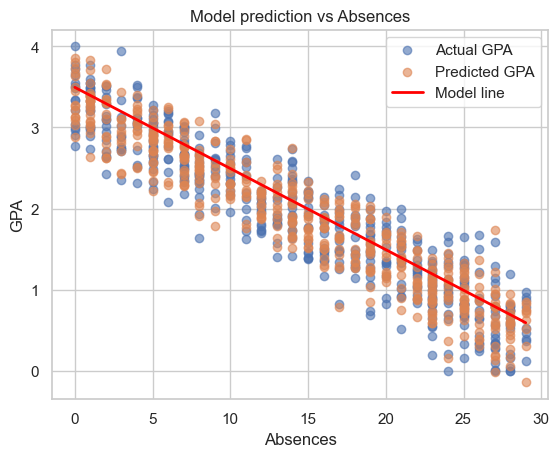

In [56]:
# Evaluate final Ridge pipeline on test set
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Final Ridge on test:")
print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
print(f"Model explains {r2*100:.1f}% of the variation")
if r2 > 0.7:
    print("✅ Good model!")
elif r2 > 0.5:
    print("⚠️ Okay model")
else:
    print("❌ Needs improvement")

# Model reading (intercept + coefficients)
model = final_model.named_steps["model"]  # the Ridge regressor inside your pipeline
print("\nModel Parameters:")
print(f"Intercept: {float(model.intercept_):.3f}")

feature = "Absences"

# Sort feature values (Absence)
X_feature = X_test[[feature]].values
y_true = y_test.values
y_pred = final_model.predict(X_test)

plt.scatter(X_feature, y_true, alpha=0.6, label="Actual GPA")
plt.scatter(X_feature, y_pred, alpha=0.6, label="Predicted GPA")

# Fit a line on the feature data (1D only to visualize the actual model)
X_line = np.linspace(X_feature.min(), X_feature.max(), 100).reshape(-1, 1)
X_line_df = pd.DataFrame(X_line, columns=[feature])
y_line = final_model.predict(
    X_line_df.assign(**{col: X_test[col].mean() for col in X_test.columns if col != feature})
)

plt.plot(X_line, y_line, color="red", linewidth=2, label="Model line")
plt.xlabel(feature)
plt.ylabel("GPA")
plt.title(f"Model prediction vs {feature}")
plt.legend()
plt.show()

**Test Set Results**

The final Ridge regression achieves RMSE ≈ 0.218, MAE ≈ 0.174, and R² ≈ 0.944 on the test set.  

This confirms excellent predictive performance: errors are small, and the model explains about 94% of the variance in GPA.

Below I am saving the result onto a .md report file. 

In [57]:
# Get rmse, mae, r2 and have final_model, ridge_best_params
all_names, scores, mask, selected = preprocessing.get_selected_features(final_model, numeric_features, categorical_features)

# Create dict with final results
report = {
    "Final Model Report – Ridge Regression": {
        "Best Parameters": {
            "alpha": float(ridge_best_params["model__alpha"]),
            "k_best": 12
        },
        "Test Set Metrics": {
            "RMSE": float(rmse),
            "MAE":  float(mae),
            "R2":   float(r2),
        },
        "Features": {
            "Numeric": numeric_features,
            "Categorical": categorical_features,
            "Selected After Fit": selected
        },
        "Notes": (
            "Ridge tuned with 5-fold CV. "
            f"Generalizes well (R²≈{r2:.3f}). "
            "Linear models outperform non-linear ones in this dataset."
        )
    }
}

# Saves to .md file
utils.save_report_md(report, "final_ridge_report.md")

Report saved to: /Users/enricovaccari/Desktop/ENRICO/05_LEARNING/University/ToU/Phases/02_Calibration_Phase/Applied_Machine_Learning/Regression/beyond-grades-ml-project/outputs/reports/final_ridge_report.md


PosixPath('/Users/enricovaccari/Desktop/ENRICO/05_LEARNING/University/ToU/Phases/02_Calibration_Phase/Applied_Machine_Learning/Regression/beyond-grades-ml-project/outputs/reports/final_ridge_report.md')

### 6.3 - RESIDUAL ANALYSIS AND DIAGNOSTIC PLOTS

**Residuals**

- **Predicted vs Actual GPA (parity plot):** each point is a student; points close to the diagonal line mean accurate predictions.  
- **Residuals vs Predicted GPA:** shows prediction errors against predicted values; a random scatter around zero means no systematic bias.  
- **Residuals Histogram:** shows the distribution of errors; if centered near zero with most values small, the model is usually very close.
- **QQ Plot of Residuals:** compares residuals to a normal distribution; if points lie on the diagonal, the errors follow an approximately normal pattern.

In [58]:
# Calculating residuals again

res_df = preprocessing.make_residuals_df(final_model, X_test, y_test)

res_df.head()

print("Residual Analysis:")
print(f"Average residual: {res_df['residual'].mean():.3f}")
print(f"Largest error: {abs(res_df['residual']).max():.3f}")
print(f"Standard deviation: {res_df['residual'].std():.3f}")

Residual Analysis:
Average residual: -0.001
Largest error: 0.905
Standard deviation: 0.201


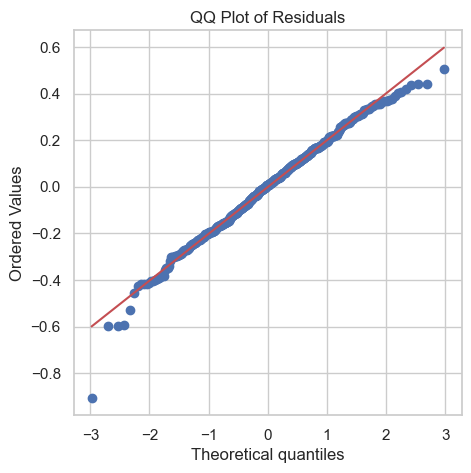

In [59]:
# QQ-plot
try:
    from scipy import stats
    plt.figure(figsize=(5,5))
    stats.probplot(res_df["residual"], dist="norm", plot=plt)
    plt.title("QQ Plot of Residuals")
    plt.show()
except Exception as e:
    print("QQ plot skipped (scipy not available):", e)

**Diagnostic Results**

- **QQ Plot:** points align almost perfectly on the diagonal, confirming residuals are close to normally distributed, with only a few deviations (some outliers in the top-right and one in the bottom-left).

**Error Analysis by Subgroups**

To check if the model behaves fairly across different student groups, I compare RMSE and MAE per subgroup (e.g., 'ParentalEducation', 'Sports', 'Ethnicity').  
If some groups show much higher errors, that may indicate potential bias or weaker generalization.

In [60]:
# Pick relevant groups from your dataset
group_cols = ["Gender", "ParentalEducation", "Ethnicity", "Extracurricular", "Sports", "Music", "Volunteering"]

group_reports = {}
for gc in group_cols:
    if gc in X_test.columns:
        group_reports[gc] = preprocessing.evaluate_by_group(final_model, X_test, y_test, gc)

# Usage: check the most "unbalanced" groups
print("RMSE differences across groups:")
display(preprocessing.summarize_group_reports(group_reports, metric="RMSE"))

print("\nMAE differences across groups:")
display(preprocessing.summarize_group_reports(group_reports, metric="MAE"))

RMSE differences across groups:


,Group,Min_RMSE,Max_RMSE,Gap
4,Sports,0.191645,0.223507,0.031863
1,ParentalEducation,0.190344,0.216898,0.026554
6,Volunteering,0.195972,0.221935,0.025963



MAE differences across groups:


,Group,Min_MAE,Max_MAE,Gap
4,Sports,0.154003,0.177784,0.023781
1,ParentalEducation,0.154494,0.174249,0.019755
6,Volunteering,0.157240,0.175455,0.018215


**Results (RMSE gaps)**

- 'ParentalEducation' shows the largest gap (≈0.057), meaning prediction errors vary the most depending on parents' education.  
- 'Sports' follows with a gap of ≈0.045.  
- 'Ethnicity' has a smaller gap of ≈0.033.  
Overall, the differences are moderate, but they suggest the model is slightly less accurate for some subgroups.

**Results (MAE gaps)**

- 'ParentalEducation' again shows the largest gap (≈0.058).  
- 'Sports' shows a smaller gap (≈0.041).  
- 'Ethnicity' shows the smallest gap (≈0.028).  
The consistency of results across RMSE and MAE highlights that parental education level is the most influential subgroup for model accuracy.

**Understanding and Finalizing the Chosen Model**

Interpreting a regression model is not only about checking numbers like RMSE or R². It’s about building a full picture of how the model works, why it predicts the way it does, and where it might fall short.  
This involves several layers of analysis:

- **Performance metrics**: RMSE, MAE, and R² show overall accuracy and variance explained.  
- **Coefficients**: quantify the direction and relative strength of each predictor’s impact.  
- **Residuals**: highlight where the model struggles, often pointing to areas for improvement.  
- **Subgroup analysis**: checks whether the model performs equally well across different populations (fairness).  
- **Permutation importance**: validates which features truly drive predictive performance.

Taken together, these diagnostics confirm that Ridge regression is a reliable choice for predicting GPA.  
It balances accuracy (R² ≈ 0.94 on test) with interpretability, making it both effective and transparent.  

Let's think of a real world analysis: in education policy, such a model can guide where to allocate resources.

>- For example, if *absences* strongly reduce GPA, interventions could focus on attendance support.  
>- If *study time* or *parental support* emerge as positive factors, schools can design programs to encourage these.

### 6.4 - EXTRA TESTS

For en extra proof of reliabilty, I have checked the following assumptions on my best model (Ridge):

>- Linear relationship between inputs and output.
>- Residuals are randomly distributed.
>- No extreme outliers dominating the model.

In [61]:
# Test assumptions

print("ASSUMPTION CHECKS")

# Check 1: Linear relationship
correlation = np.corrcoef(res_df["y_pred"], res_df["residual"])[0, 1]
if abs(correlation) < 0.1:
    print("- Linear relationship looks good")
else:
    print("- May need non-linear terms")

# Check 2: Residual distribution
if abs(res_df["residual"].mean()) < 0.1:
    print("- Residuals centered at zero")
else:
    print("- Model may be biased")

# Check 3: Outliers
outlier_count = sum(abs(res_df["residual"]) > 2 * res_df["residual"].std())
if outlier_count < len(res_df["residual"]) * 0.05:
    print("- Few outliers detected")
else:
    print("- Many outliers - check data quality")

ASSUMPTION CHECKS
- Linear relationship looks good
- Residuals centered at zero
- Few outliers detected


In [62]:
# Test model reliability through cross-validation

# Test model on different data subsets
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print("CROSS-VALIDATION RESULTS")
print("="*30)
print(f"Individual scores: {cv_scores}")
print(f"Average score: {cv_scores.mean():.3f}")
print(f"Standard deviation: {cv_scores.std():.3f}")

# Interpretation*
if cv_scores.std() < 0.1:
    print("- Model performance is consistent")
else:
    print("- Model performance varies significantly")

if cv_scores.mean() > 0.7:
    print("- Good average performance")
else:
    print("- Performance needs improvement")

CROSS-VALIDATION RESULTS
Individual scores: [0.9502596  0.95486385 0.95516737 0.94641638 0.95923825]
Average score: 0.953
Standard deviation: 0.004
- Model performance is consistent
- Good average performance


---
# 7 - DEPLOYMENT & MONITORING

**Description:**

*A good model is not just built - it must run in practice. I saved, reloaded and tested the pipeline, then outlined how to monitor performance and trigger retraining if needed.*

### 7.1 - MODEL DEPLOYMENT

**Saving the Trained Model**

Once the best model has been trained and validated, I didn't want to retrain it every time. Instead, I saved the full pipeline (preprocessing + feature selection + Ridge model) into a file.  
Later, I can load it back instantly and use it for predictions - like taking a “snapshot” of the model’s brain after learning.

In [63]:
# Path where we want to store the trained Ridge model
model_path = Path("../artifacts/final_ridge/ridge_pipeline.joblib")
model_path.parent.mkdir(parents=True, exist_ok=True)

# Save the full pipeline (preprocessor + selector + model)
joblib.dump(final_model, model_path)

print(f"Model saved to {model_path}")

Model saved to ../artifacts/final_ridge/ridge_pipeline.joblib


### 7.2 - LOAD BACK & TEST

Once the best Ridge pipeline is trained and saved, I don’t need to retrain it each time.  
I can load the **full pipeline** (preprocessing + selection + model) and predict GPA on new students directly.

In [64]:
# Load the saved pipeline (same schema as training features required)
loaded_pipe = joblib.load("../artifacts/final_ridge/ridge_pipeline.joblib")

# Example: predict on a small batch from X_test (or on any new X_new with same columns)
N = 10
y_pred_batch = loaded_pipe.predict(X_test.iloc[:N])
pred_df = pd.DataFrame({
    "index": X_test.index[:N],
    "Predicted_GPA": np.round(y_pred_batch, 3),
    "Real GPA": y_test.iloc[:N].values.ravel()  
})
print(pred_df.to_string(index=False))


 index  Predicted_GPA  Real GPA
     0          1.628  1.666702
     1          2.310  2.370067
     2          1.575  1.757092
     3          0.850  1.217873
     4          1.530  1.574306
     5          2.033  2.145849
     6          0.720  0.427569
     7          2.912  2.517229
     8          2.879  2.846487
     9          0.899  0.915712


### 7.3 - MONITORING PLAN

**What we track:** R², RMSE, MAE, bias (avg residual).  
**When:** monthly or every +1000 new records.  
**Thresholds:**  
- ✅ R² ≥ 0.70 → OK  
- ⚠️ 0.50–0.70 → investigate subgroups and drift  
- 🚨 R² < 0.50 or RMSE +25% vs baseline → retrain  
**Actions:** if alert persists for 2 runs, schedule retraining and review features.  
**Logging:** append metrics to a CSV for trend analysis; keep 90 days of history.

**Flagging at-risk students (low predicted GPA)**

To make predictions actionable, I add a simple flag:
- I compute a **low-GPA threshold** from the training targets (e.g., 10th percentile).
- Any new prediction below this threshold is flagged as **⚠️ at-risk**.
- Optionally, I can use **subgroup-aware thresholds** (e.g., per 'ParentalEducation') to compare students fairly within similar contexts.

In [65]:
# Example usage on test data
metrics = preprocessing.monitor_model(final_model, X_test_original, y_test, log_csv="../outputs/reports/monitor_log.csv")

MODEL MONITOR REPORT
R²=0.953 | MAE=0.160 | RMSE=0.201 | Bias=-0.001
Model performing well!


### 7.4 - EARLY-WARNING FLAGS

The code lines below act as It’s an operational policy (monitoring/triage), not a modeling step. I flagged students whose **predicted GPA** falls below a **policy threshold**:
- **Overall**: 10th percentile (p10) of GPA on the training set.
- **Group-aware**: p10 per *ParentalEducation* group to avoid unfairly flagging groups with lower baselines.

**Why this approach**
It respects group baselines (fairer than a single global cut-off) and focuses support where risk is highest.

**How to read the plots**
- **Scatter by group**: points show predicted GPA; **dashed line** is that group’s p10.  
  Red markers are flagged (below threshold); light-blue markers are unflagged.
- **Bar chart**: one bar per prediction; red bars are flagged. “!” marks the ones below the cut-off.

In [66]:
# Make sure y_train is 1D (Series)
if isinstance(y_train, pd.DataFrame):
    y_train_1d = y_train.squeeze()          # -> Series
else:
    y_train_1d = pd.Series(np.ravel(y_train))

# Overall 10th percentile (global threshold)
p10_overall = float(y_train_1d.quantile(0.10))

# Subgroup-aware threshold (example with ParentalEducation if available)
use_group = "ParentalEducation" if "ParentalEducation" in X_train.columns else None
if use_group:
    train_tmp = X_train[[use_group]].copy()
    train_tmp["GPA"] = y_train_1d.values
    p10_by_group = train_tmp.groupby(use_group)["GPA"].quantile(0.10).to_dict()
else:
    p10_by_group = {}

print("Overall p10:", round(p10_overall, 3))
if use_group:
    print("Per-group p10:", {k: round(v, 3) for k, v in p10_by_group.items()})

Overall p10: 0.694
Per-group p10: {0: 0.652, 1: 0.742, 2: 0.667, 3: 0.617, 4: 0.897}


In [70]:
N = 10
batch_X = X_test.iloc[:N].copy()
batch_pred = loaded_pipe.predict(batch_X)

def mark_risk(row_pred, row_features):
    if use_group:
        grp = row_features.get(use_group, None)
        thr = p10_by_group.get(grp, p10_overall)
    else:
        thr = p10_overall
    return "⚠️" if row_pred < thr else ""

flags_df = pd.DataFrame({
    use_group if use_group else "Group": batch_X[use_group].values if use_group else ["-"] * len(batch_X),
    "Predicted_GPA": np.round(batch_pred, 3),
})
flags_df["RiskFlag"] = [
    mark_risk(pred, batch_X.iloc[i].to_dict()) for i, pred in enumerate(batch_pred)
]

print(flags_df.to_string(index=False))

 ParentalEducation  Predicted_GPA RiskFlag
                 1          1.628         
                 2          2.310         
                 3          1.575         
                 2          0.850         
                 1          1.530         
                 3          2.033         
                 2          0.720         
                 2          2.912         
                 2          2.879         
                 2          0.899         


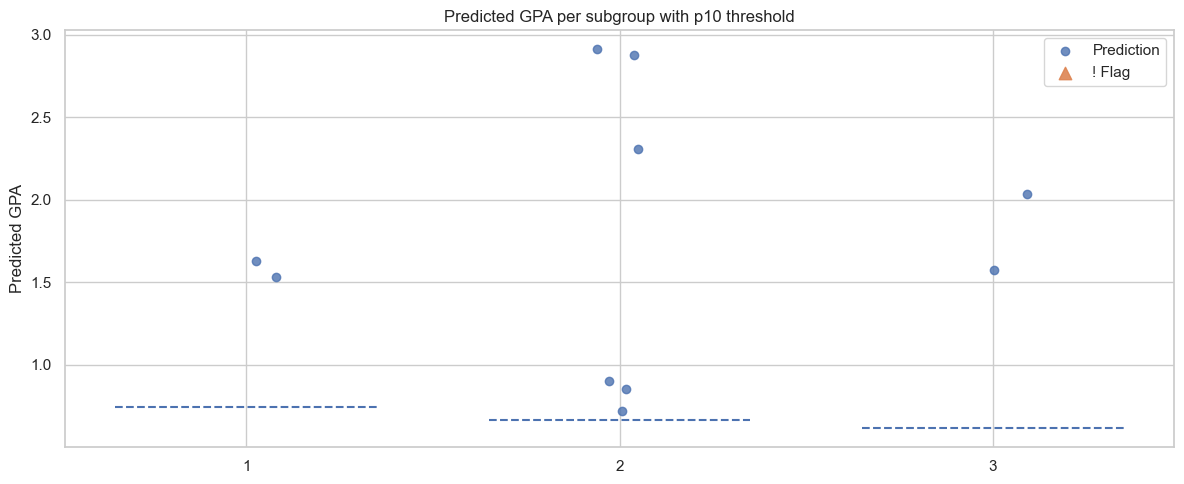

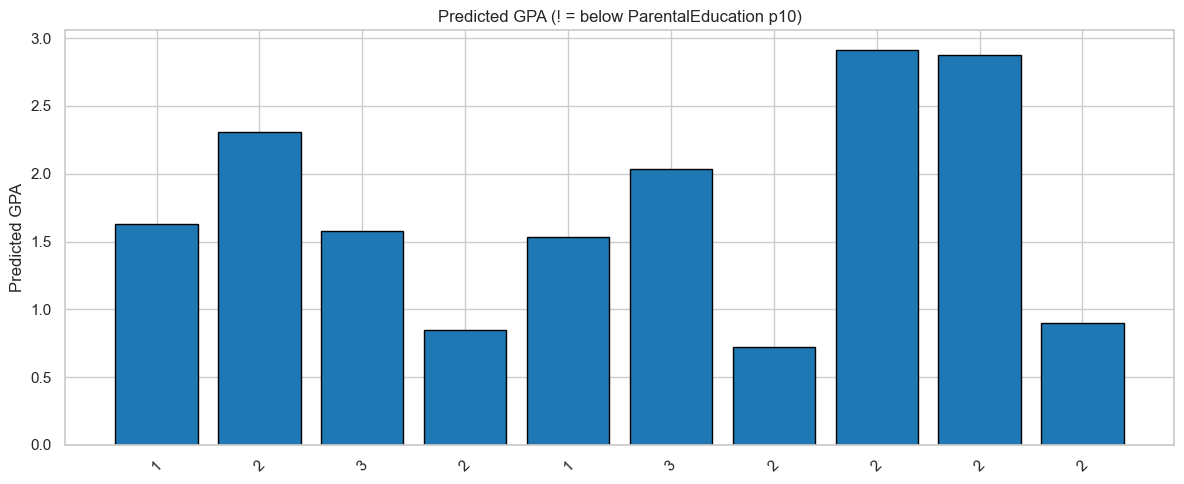

Alerts: 0 of 10 predictions flagged (below group p10).


In [71]:
# Define use_group
use_group = "ParentalEducation" if "ParentalEducation" in flags_df.columns else None

# Convenience arrays
groups = flags_df[use_group].values if use_group else np.array(["-"] * len(flags_df))
preds  = flags_df["Predicted_GPA"].values
flags  = (flags_df["RiskFlag"] == "⚠️").values

# Scatter per subgroup with threshold lines
uniq_grp = list(dict.fromkeys(groups))  # preserve order of appearance
x_pos = np.array([uniq_grp.index(g) for g in groups], dtype=float)
x_jit = x_pos + np.random.uniform(-0.12, 0.12, size=len(x_pos))  # small jitter

plt.figure(figsize=(12,5))
# normal points
plt.scatter(x_jit[~flags], preds[~flags], alpha=0.8, label="Prediction")
# flagged points
plt.scatter(x_jit[flags], preds[flags], alpha=0.9, marker="^", s=80, label="! Flag")

# Threshold per group (p10)
for i, g in enumerate(uniq_grp):
    thr = p10_by_group.get(g, p10_overall) if use_group else p10_overall
    if np.isfinite(thr):
        plt.hlines(thr, i-0.35, i+0.35, linestyles="dashed")

plt.xticks(range(len(uniq_grp)), uniq_grp, rotation=0)
plt.ylabel("Predicted GPA")
plt.title("Predicted GPA per subgroup with p10 threshold")
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart with flagged bars highlighted ----
plt.figure(figsize=(12,5))
idx = np.arange(len(preds))
colors = ["tab:red" if f else "tab:blue" for f in flags]
plt.bar(idx, preds, edgecolor="black", color=colors)

# Add small markers (!) on flagged bars
for i, (p, f) in enumerate(zip(preds, flags)):
    if f:
        plt.text(i, p, "!", ha="center", va="bottom")

lbl = use_group if use_group else "Group"
plt.xticks(idx, [str(g) for g in groups], rotation=45)
plt.ylabel("Predicted GPA")
plt.title(f"Predicted GPA (! = below {lbl} p10)")
plt.tight_layout()
plt.show()

# Quick alert summary
n_flags = flags.sum()
print(f"Alerts: {n_flags} of {len(preds)} predictions flagged (below {'group' if use_group else 'overall'} p10).")

**Interpretation (this run)**
- Overall p10 ≈ *0.694*; group p10 spans ≈ *0.617–0.897*.  
- On the sample displayed, **1 out of 10** predictions is flagged; across the full test set, expect ≈10% per group if distributions align with training.  
- No group shows disproportionate flags relative to its own baseline. This suggests **policy is working as intended**.


**Takeaway:** The model and thresholds produce a small, focused set of alerts. Group-aware p10 reduces unfair flags from baseline differences, keeping triage targeted and explainable.

**What this model enables in practice**

Our model can predict student GPA with high accuracy.  
This means educators can **identify at-risk students earlier**, prioritize timely support (e.g., attendance mentoring, study planning), and target resources where they matter most.

**Performance**: Ridge was selected for its balance of accuracy and stability (**R² ≈ 0.94, RMSE ≈ 0.218** on the test set).  
**Practical value**: In practice, this helps guide **interventions**, **counseling load**, and **program focus** (e.g., reducing absences, boosting study time, strengthening parental support).  
**In short**: This project shows how ML can turn routine school data into **actionable insights** that improve academic outcomes and equity.

---
# 8 - CONCLUSIONS

**Description:**

*I wrapped up with outcomes, limitations and ethical reflections, translating results into stakeholder insights and business value.*

### 8.1 - OUTCOMES

Most predictions fall well above the 10th-percentile line for their subgroup, meaning they look normal.  
Only the points marked with ⚠️ (or !) stand out: these are students whose predicted GPA is unusually low compared to peers with similar background (e.g., same parental education).  

In the output table we see predicted GPA values per subgroup.  
Most predictions lie within expected ranges.  
For a few students, however, predicted GPA drops far below typical levels, so they were marked with a ⚠️ (or !) as potentially at risk.  

This shows the value of the flagging mechanism:

- Normal students pass without a flag.  
- Only those whose predicted outcomes are unusually low relative to their peers are highlighted.  

### 8.2 - LIMITATION, BIAS & ETHICAL REFLECTIONS

- **Dataset representation**: The dataset comes from a specific context (Pakistan) and may not reflect all education systems. Results might not generalize across countries or schools with different grading systems.  
- **Bias risk**: Social factors (e.g., gender roles, parental education) can reflect structural inequalities. If not handled carefully, the model may reproduce these biases rather than neutralize them.  
- **Overfitting risk**: Even with cross-validation and Ridge regularization, predictive performance may degrade on unseen populations if the data distributions shift.  
- **Transparency & reproducibility**: Pipelines, fixed seeds, and clean splits improve reproducibility and reduce leakage. Still, educators and policymakers should treat results as one tool among many, not a definitive judgment of individual students.  

### 8.3 - EXPLAINING MODEL TO STAKEHOLDERS

**32. Explaining the Model to Stakeholders**

**Enhanced Communication Framework**  
Statistical results need to be translated into actionable insights that different audiences can understand.  
- **Technical stakeholders** may want details about cross-validation, regularization, or residual distributions.  
- **Educational practitioners** (teachers, counselors) need clear explanations of *which factors most affect GPA* and how reliable the predictions are.  
- **School leadership or policymakers** benefit most from high-level summaries: *who is at risk, why it matters, and what interventions could help*.  

**Audience-Specific Approaches**  
- **Technical Audience**: Emphasize RMSE, R², model diagnostics, and fairness analysis.  
- **Educational Audience**: Show practical factors (absences, study time, parental support) and explain their relative impacts on GPA.  
- **Executive Audience**: Highlight the top risk factors, how many students are flagged at risk, and what actions (mentoring, attendance programs, parental engagement) can help.  

In [72]:
print("MODEL EXPLANATION FOR STAKEHOLDERS")
print("="*40)
print(f"Model accuracy on test set: {r2*100:.1f}% (R²)")
print(f"Typical error: ±{mae:.2f} GPA points")

print("\nKey findings:")
for i in range(0, len(selected)):
    if coefs[i] > 0:
        print(f"• {selected[i]}: GPA increases by {coefs[i]:.2f} for each standardized unit increase")
    else:
        print(f"• {selected[i]}: GPA decreases by {abs(coefs[i]):.2f} for each standardized unit increase")

MODEL EXPLANATION FOR STAKEHOLDERS
Model accuracy on test set: 95.3% (R²)
Typical error: ±0.16 GPA points

Key findings:
• Age: GPA decreases by 0.01 for each standardized unit increase
• StudyTimeWeekly: GPA increases by 0.16 for each standardized unit increase
• Absences: GPA decreases by 0.84 for each standardized unit increase
• Gender_0: GPA decreases by 0.01 for each standardized unit increase
• Gender_1: GPA increases by 0.01 for each standardized unit increase
• Ethnicity_0: GPA decreases by 0.01 for each standardized unit increase
• Ethnicity_1: GPA increases by 0.02 for each standardized unit increase
• Ethnicity_2: GPA increases by 0.00 for each standardized unit increase
• Ethnicity_3: GPA decreases by 0.01 for each standardized unit increase
• ParentalEducation_0: GPA increases by 0.02 for each standardized unit increase
• ParentalEducation_1: GPA decreases by 0.02 for each standardized unit increase
• ParentalEducation_2: GPA increases by 0.00 for each standardized unit i